# Using Statistics Canada Data to Assist in Determining the Halifax Public Library Branch Most in Need of a Social Worker
### By: Vinson Li

Public libraries are important places for marginalized peoples and individuals experiencing homelessness `(Lloyd, 2020)`. Sometimes the library is the only place where these groups of people can find assistance for the various problems they may be going through. Librarians and other library workers are not traditionally trained to best help these people and thus, some public libraries have begun experimenting with embedding social workers into public libraries `(Clink, 2020)`. 

The Halifax public library (HPL) have also been involved in this endeavour with a single social worker in the central branch `(Skultety, 2020)`. Manifestly, other areas of the Halifax regional municipality (HRM) would benefit with a social worker at their local HPL branch, but realistically, there likely isn't enough room in the budget to accomidate that ambition. Therefore, the question becomes which HPL branch would benefit most from the addition of a social worker?

##### How the Question will be Answered

I will attempt to answer this question using data science. Statistics Canada has data on the homeless shelter capacities of each municipality in Canada which will be used as a proxy for homelessness rates `(Statistics Canada, August 2017)`. Looking at the census data of each of those municipalities, the correlation between certain census statistics and shelter capacity can tell us how good of a surrogate marker that statistic can be for measuring homelessness rates. I will test low income prevalence and unemployment rate as candidates for surrogate marker. 

The HPL website has a map showing the locations of all their branches `(Halifax Public Libraries, 2021)`. On the 2016 census from Statistics Canada, the HRM is divided into census tracts `(Statistics Canada, February 2017)`, the areas serviced by each HPL branch can be roughly defined by a group of census tracts. The census data for each census tract can be used to measure the total number of people in the area serviced by a particular HPL branch who are living with unemployment or low income status which based on the correlation calculations will give an idea about the homelessness prevalence of that HPL brnach area `(Statistics Canada, February 2017)`. 

###### Importing All Necessary Libraries

The analysis of the data will be done using Python. The code below imports all the libraries needed to do the analysis. 

- `csv` allows us to read and write CSV files (essentially Excel files) on which the tables of data will be stored.
- `requests` allows us to call on application programing interfaces (APIs) which is one way that Statistics Canada allows users to interact with their data.
- `pandas` is used to create dataframes which allows for more flexible manipulation of the data we wish to analyse. 
- `numpy` assists `pandas` in data manipulation.
- `matplotlib` is a data visualization library that interacts with 'pandas'.
- `seaborn` is another data visualization library that can help make better visualizations
- `scipy` is used for statistical analysis. 

In [1]:
import csv #imports csv reader/writer
import requests # import the requests library (allows access to APIs)

In [2]:
import pandas as pd # import pandas 
import numpy as np # import numpy
import matplotlib.pyplot as plt # imports matplotlib
import seaborn as sns # imports seaborn for data visualization

from scipy import stats # the scipy stats module

sns.set_theme() # set seaborn

###### Retrieving Municipal Homeless Shelter Data from Statistics Canada

A CSV file containing all the data on municipal homeless shelter statistics can be downloaded from [Statistic Canada](https://www150.statcan.gc.ca/n1/tbl/csv/14100353-eng.zip). Unnessesary columns of data can be deleted using Excel leaving the data to look like this:

![figure_2](CSV_Data_Files/Figure_2.png "Excel Formula")

The homeless shelter capacity table has each municipality tagged with a [Dissemination Geography Unique Identifier (DGUID)](https://www150.statcan.gc.ca/n1/pub/92f0138m/92f0138m2019001-eng.htm) which with the Census API can be used to retrieve the census data for that location. 

We can call on the census data for those locations to retrieve data on unemployment rate, low income prevalence, and population. Then we can pair the census data about that location with the corresponding homeless shelter data to create a CSV file that has all the relevant data; each row describing one municipality. This will then allow us to calculate the correlation between homelessness and unemployment/low income prevalence. 

###### How the Code below Works

The CSV file containing the cleaned homeless shelter per municipality data (i.e. `Municipal_Homess_Shelter_Stats.csv`) is read and each row is placed into a list `shelt`. Then for each row the census API is called upon. 

First, it checks if that row has a DGUID by checking if the second item on that row has a length that isn't zero (i.e. `if len(row) > 1`). Each row of data contains data about a specific type of homeless shelter and therefore a single municiplaity can occupy many rows. Since calling on an API can take time, we only want to call on the API for each municipality once. Because all municipalities have their rows grouped together, we can check if the previous row of data's DGUID matches with the current row's DGUID (i.e. `if shelt[a-1][1] != row[1]`), a mismatch will only happen when the data reaches a new municipality. `a` is a variable that counts up for every row of data and is used to call on the previous row created in `shelt` to comapire DGUIDs. 

The census API's URL is explained [here](https://www12.statcan.gc.ca/wds-sdw/cpr2016-eng.cfm) and the part of the URL that varies with each location is the DGUID. The DGUIDs provided by the homeless shelter CSV call on the 2011 census, thus to get the 2016 census we add `2016` to the URL and index the part of the DGUID after the year. `census_temp` is a list that hold data from the census API. First, `if len(query['DATA']) != 0` checks to make sure the census data actually has data. Because the locations of all specific data points in the census are the same for all municipalities, the same index numbers can be used to find all the data. The census API data from `census_temp` is then added onto the corresponding `shelt` row. 

If the census data has been called upon previously, the census data is retrived from the previous row in `shelt` and added to the current row.

Once the census data is in place for the row, it is then written onto a new CSV file `Homeless_census.csv`. The code on how to write on a CSV file without deleting previously written data was obtained from [Stack Overflow](https://stackoverflow.com/questions/20791354/write-to-csv-on-first-empty-line) `(πόδας ὠκύς, 2013)`.

In [123]:
shelt = [] # list holds the shelter data

with open('Municipal_Homess_Shelter_Stats.csv', newline='') as csvfile: # reads the csv file with the shelter data stored
    shelt_reader = csv.reader(csvfile, delimiter=',')
    
    census_temp = [] # temporary storage for census data that we'll grab for each location
    a = 0 # counts the rows in shelt
    
    for row in shelt_reader: # grabs the shelter data for each row and places it on a list (the list will be placed in a csv later)
        if len(row) > 1: # checks to make sure the row has data
            shelt.append(row) 
            
            if len(row[1]) != 0: # i.e. if the location has a DGUID that links to census data
                if shelt[a-1][1] != row[1]: # checks if the DGUID of the current row is different from the previous row to prevent calling the API more than once per municipality 
                    response = requests.get('https://www12.statcan.gc.ca/rest/census-recensement/CPR2016.json?lang=E&dguid=' + "2016" + str(row[1][4:]) + '&topic=0&notes=0&stat=0')
                    # grabs the 2016 census data on the census tract that corresponds to the DGUID
                    query = response.json() # retrieve JSON data

                    if len(query['DATA']) != 0: #checks if the JSON data actually has census data
                        census_temp.append(query['DATA'][0][1]) # adds province to list (for checking purposes, will delete on excel later)
                        census_temp.append(query['DATA'][0][4]) # adds municipality to list (for checking purposes, will delete on excel later)
                        census_temp.append(query['DATA'][1871][13]) # adds unemployment rate to list
                        census_temp.append(query['DATA'][856][13]) # adds low income prevalence % to list
                        census_temp.append(query['DATA'][0][13]) # adds population to list
                        
                        shelt[a].extend(census_temp) # adds the census data to the row of homeless shelter data

                        census_temp.clear() #cleans the census data list holder for the next row
                else:
                    row.extend(shelt[a-1][6:]) # if the census data for the location was previous retrieved, that data will be copied over to the next row
            with open('Homeless_census.csv', 'a', newline='') as csvfile: # appends 'shelt' list to a new CSV file
                Homeless_census_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
                Homeless_census_writer.writerow(shelt[a])
                # https://stackoverflow.com/questions/20791354/write-to-csv-on-first-empty-line
            
            print(shelt[a]) # visually shows process of data extraction
            a += 1 # counts up a

['ï»¿Canada', '2016A000011124', 'Emergency', 'General - both genders', 'Number of shelters', '130']
['Canada', '2016A000011124', 'Emergency', 'General - both genders', 'Number of beds', '5535']
['Canada', '2016A000011124', 'Emergency', 'General - males', 'Number of shelters', '71']
['Canada', '2016A000011124', 'Emergency', 'General - males', 'Number of beds', '4527']
['Canada', '2016A000011124', 'Emergency', 'General - females', 'Number of shelters', '70']
['Canada', '2016A000011124', 'Emergency', 'General - females', 'Number of beds', '2091']
['Canada', '2016A000011124', 'Emergency', 'Youth', 'Number of shelters', '98']
['Canada', '2016A000011124', 'Emergency', 'Youth', 'Number of beds', '1536']
['Canada', '2016A000011124', 'Emergency', 'Family', 'Number of shelters', '32']
['Canada', '2016A000011124', 'Emergency', 'Family', 'Number of beds', '1720']
['Canada', '2016A000011124', 'Transitional Housing', 'General - both genders', 'Number of shelters', '89']
['Canada', '2016A000011124', 

['Corner Brook, Newfoundland and Labrador', '2011A00051005018', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Corner Brook', 13.3, 16.9]
['Corner Brook, Newfoundland and Labrador', '2011A00051005018', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Newfoundland and Labrador', 'Corner Brook', 13.3, 16.9]
['Corner Brook, Newfoundland and Labrador', '2011A00051005018', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Corner Brook', 13.3, 16.9]
['Corner Brook, Newfoundland and Labrador', '2011A00051005018', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', 'Corner Brook', 13.3, 16.9]
['Corner Brook, Newfoundland and Labrador', '2011A00051005018', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Corner Brook', 13.3, 16.9]
['Corner Brook, Newfoundland and Labrador', '2011A00051005018', 'Emergency', 'General - fema

['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.3, 7.4]
['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.3, 7.4]
['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.3, 7.4]
['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.3, 7.4]
['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.

['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - fem

['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - females', '

["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - both genders', 'Number of shelters', '2', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - both genders', 'Number of beds', '24', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - females', 'Number of beds', '0

['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - males', 'Number of shelters', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - males', 'Number of beds', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - females', 'Number of shelters', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - females', 'Number of beds', '0', 'Prin

['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - males', 'Number of shelters', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - males', 'Number of beds', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - females', 'Number of shelters', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - females', 'Number of beds', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'Youth', 'Number of shelters', '0', 'Nova Scotia', 

['Halifax, Nova Scotia', '2011A00051209034', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Nova Scotia', 'Halifax', 7.3, 14.8]
['Halifax, Nova Scotia', '2011A00051209034', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Nova Scotia', 'Halifax', 7.3, 14.8]
['Halifax, Nova Scotia', '2011A00051209034', 'Emergency', 'General - males', 'Number of shelters', '2', 'Nova Scotia', 'Halifax', 7.3, 14.8]
['Halifax, Nova Scotia', '2011A00051209034', 'Emergency', 'General - males', 'Number of beds', '120', 'Nova Scotia', 'Halifax', 7.3, 14.8]
['Halifax, Nova Scotia', '2011A00051209034', 'Emergency', 'General - females', 'Number of shelters', '2', 'Nova Scotia', 'Halifax', 7.3, 14.8]
['Halifax, Nova Scotia', '2011A00051209034', 'Emergency', 'General - females', 'Number of beds', '36', 'Nova Scotia', 'Halifax', 7.3, 14.8]
['Halifax, Nova Scotia', '2011A00051209034', 'Emergency', 'Youth', 'Number of shelters', '1', 'Nova Scotia', 'Halifax', 7.3, 14.8]
['Halifax, Nov

['Port Hawkesbury, Nova Scotia', '2011A00051215002', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Nova Scotia', 'Port Hawkesbury', 13.1, 20.6]
['Port Hawkesbury, Nova Scotia', '2011A00051215002', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Nova Scotia', 'Port Hawkesbury', 13.1, 20.6]
['Port Hawkesbury, Nova Scotia', '2011A00051215002', 'Emergency', 'General - males', 'Number of shelters', '0', 'Nova Scotia', 'Port Hawkesbury', 13.1, 20.6]
['Port Hawkesbury, Nova Scotia', '2011A00051215002', 'Emergency', 'General - males', 'Number of beds', '0', 'Nova Scotia', 'Port Hawkesbury', 13.1, 20.6]
['Port Hawkesbury, Nova Scotia', '2011A00051215002', 'Emergency', 'General - females', 'Number of shelters', '0', 'Nova Scotia', 'Port Hawkesbury', 13.1, 20.6]
['Port Hawkesbury, Nova Scotia', '2011A00051215002', 'Emergency', 'General - females', 'Number of beds', '0', 'Nova Scotia', 'Port Hawkesbury', 13.1, 20.6]
['Port Hawkesbury, Nova Scotia', '2011A0005121

['Yarmouth, Nova Scotia', '2011A00051202004', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Nova Scotia', 'Yarmouth', 8.2, 17.1]
['Yarmouth, Nova Scotia', '2011A00051202004', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Nova Scotia', 'Yarmouth', 8.2, 17.1]
['Yarmouth, Nova Scotia', '2011A00051202004', 'Emergency', 'General - males', 'Number of shelters', '0', 'Nova Scotia', 'Yarmouth', 8.2, 17.1]
['Yarmouth, Nova Scotia', '2011A00051202004', 'Emergency', 'General - males', 'Number of beds', '0', 'Nova Scotia', 'Yarmouth', 8.2, 17.1]
['Yarmouth, Nova Scotia', '2011A00051202004', 'Emergency', 'General - females', 'Number of shelters', '0', 'Nova Scotia', 'Yarmouth', 8.2, 17.1]
['Yarmouth, Nova Scotia', '2011A00051202004', 'Emergency', 'General - females', 'Number of beds', '0', 'Nova Scotia', 'Yarmouth', 8.2, 17.1]
['Yarmouth, Nova Scotia', '2011A00051202004', 'Emergency', 'Youth', 'Number of shelters', '0', 'Nova Scotia', 'Yarmouth', 8.2, 17.1]
['Y

['Campbellton, New Brunswick', '2011A00051314014', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'New Brunswick', 'Campbellton', 11.0, 27.7]
['Campbellton, New Brunswick', '2011A00051314014', 'Emergency', 'General - both genders', 'Number of beds', '0', 'New Brunswick', 'Campbellton', 11.0, 27.7]
['Campbellton, New Brunswick', '2011A00051314014', 'Emergency', 'General - males', 'Number of shelters', '0', 'New Brunswick', 'Campbellton', 11.0, 27.7]
['Campbellton, New Brunswick', '2011A00051314014', 'Emergency', 'General - males', 'Number of beds', '0', 'New Brunswick', 'Campbellton', 11.0, 27.7]
['Campbellton, New Brunswick', '2011A00051314014', 'Emergency', 'General - females', 'Number of shelters', '0', 'New Brunswick', 'Campbellton', 11.0, 27.7]
['Campbellton, New Brunswick', '2011A00051314014', 'Emergency', 'General - females', 'Number of beds', '0', 'New Brunswick', 'Campbellton', 11.0, 27.7]
['Campbellton, New Brunswick', '2011A00051314014', 'Emergency', 'Youth

['Miramichi, New Brunswick', '2011A00051309050', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'New Brunswick', 'Miramichi', 13.7, 17.0]
['Miramichi, New Brunswick', '2011A00051309050', 'Emergency', 'General - both genders', 'Number of beds', '0', 'New Brunswick', 'Miramichi', 13.7, 17.0]
['Miramichi, New Brunswick', '2011A00051309050', 'Emergency', 'General - males', 'Number of shelters', '0', 'New Brunswick', 'Miramichi', 13.7, 17.0]
['Miramichi, New Brunswick', '2011A00051309050', 'Emergency', 'General - males', 'Number of beds', '0', 'New Brunswick', 'Miramichi', 13.7, 17.0]
['Miramichi, New Brunswick', '2011A00051309050', 'Emergency', 'General - females', 'Number of shelters', '0', 'New Brunswick', 'Miramichi', 13.7, 17.0]
['Miramichi, New Brunswick', '2011A00051309050', 'Emergency', 'General - females', 'Number of beds', '0', 'New Brunswick', 'Miramichi', 13.7, 17.0]
['Miramichi, New Brunswick', '2011A00051309050', 'Emergency', 'Youth', 'Number of shelters', '

['St. Stephen, New Brunswick', '2011A00051302037', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'New Brunswick', 'St. Stephen', 16.7, 26.9]
['St. Stephen, New Brunswick', '2011A00051302037', 'Emergency', 'General - both genders', 'Number of beds', '0', 'New Brunswick', 'St. Stephen', 16.7, 26.9]
['St. Stephen, New Brunswick', '2011A00051302037', 'Emergency', 'General - males', 'Number of shelters', '0', 'New Brunswick', 'St. Stephen', 16.7, 26.9]
['St. Stephen, New Brunswick', '2011A00051302037', 'Emergency', 'General - males', 'Number of beds', '0', 'New Brunswick', 'St. Stephen', 16.7, 26.9]
['St. Stephen, New Brunswick', '2011A00051302037', 'Emergency', 'General - females', 'Number of shelters', '0', 'New Brunswick', 'St. Stephen', 16.7, 26.9]
['St. Stephen, New Brunswick', '2011A00051302037', 'Emergency', 'General - females', 'Number of beds', '0', 'New Brunswick', 'St. Stephen', 16.7, 26.9]
['St. Stephen, New Brunswick', '2011A00051302037', 'Emergency', 'Youth

['Woodstock, New Brunswick', '2011A00051311004', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'New Brunswick', 'Woodstock', 6.3, 14.9]
['Woodstock, New Brunswick', '2011A00051311004', 'Emergency', 'General - both genders', 'Number of beds', '0', 'New Brunswick', 'Woodstock', 6.3, 14.9]
['Woodstock, New Brunswick', '2011A00051311004', 'Emergency', 'General - males', 'Number of shelters', '0', 'New Brunswick', 'Woodstock', 6.3, 14.9]
['Woodstock, New Brunswick', '2011A00051311004', 'Emergency', 'General - males', 'Number of beds', '0', 'New Brunswick', 'Woodstock', 6.3, 14.9]
['Woodstock, New Brunswick', '2011A00051311004', 'Emergency', 'General - females', 'Number of shelters', '0', 'New Brunswick', 'Woodstock', 6.3, 14.9]
['Woodstock, New Brunswick', '2011A00051311004', 'Emergency', 'General - females', 'Number of beds', '0', 'New Brunswick', 'Woodstock', 6.3, 14.9]
['Woodstock, New Brunswick', '2011A00051311004', 'Emergency', 'Youth', 'Number of shelters', '0', 'N

['Baie-Comeau, Quebec', '2011A00052496020', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Baie-Comeau', 7.7, 9.3]
['Baie-Comeau, Quebec', '2011A00052496020', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Baie-Comeau', 7.7, 9.3]
['Baie-Comeau, Quebec', '2011A00052496020', 'Emergency', 'General - males', 'Number of shelters', '1', 'Quebec', 'Baie-Comeau', 7.7, 9.3]
['Baie-Comeau, Quebec', '2011A00052496020', 'Emergency', 'General - males', 'Number of beds', '17', 'Quebec', 'Baie-Comeau', 7.7, 9.3]
['Baie-Comeau, Quebec', '2011A00052496020', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Baie-Comeau', 7.7, 9.3]
['Baie-Comeau, Quebec', '2011A00052496020', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Baie-Comeau', 7.7, 9.3]
['Baie-Comeau, Quebec', '2011A00052496020', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Baie-Comeau', 7.7, 9.3]
['Baie-Comeau, Quebec', '2011A0005249

['Chambly, Quebec', '2011A00052457005', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Chambly', 4.0, 6.5]
['Chambly, Quebec', '2011A00052457005', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Chambly', 4.0, 6.5]
['Chambly, Quebec', '2011A00052457005', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Chambly', 4.0, 6.5]
['Chambly, Quebec', '2011A00052457005', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Chambly', 4.0, 6.5]
['Chambly, Quebec', '2011A00052457005', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Chambly', 4.0, 6.5]
['Chambly, Quebec', '2011A00052457005', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Chambly', 4.0, 6.5]
['Chambly, Quebec', '2011A00052457005', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Chambly', 4.0, 6.5]
['Chambly, Quebec', '2011A00052457005', 'Emergency', 'Youth', 'Number of beds', '0', 'Quebec',

['Cowansville, Quebec', '2011A00052446080', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Cowansville', 8.0, 18.1]
['Cowansville, Quebec', '2011A00052446080', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Cowansville', 8.0, 18.1]
['Cowansville, Quebec', '2011A00052446080', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Cowansville', 8.0, 18.1]
['Cowansville, Quebec', '2011A00052446080', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Cowansville', 8.0, 18.1]
['Cowansville, Quebec', '2011A00052446080', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Cowansville', 8.0, 18.1]
['Cowansville, Quebec', '2011A00052446080', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Cowansville', 8.0, 18.1]
['Cowansville, Quebec', '2011A00052446080', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Cowansville', 8.0, 18.1]
['Cowansville, Quebec', '2011A0

['Fermont, Quebec', '2011A00052497035', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Fermont', 5.6, 2.0]
['Fermont, Quebec', '2011A00052497035', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Fermont', 5.6, 2.0]
['Fermont, Quebec', '2011A00052497035', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Fermont', 5.6, 2.0]
['Fermont, Quebec', '2011A00052497035', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Fermont', 5.6, 2.0]
['Fermont, Quebec', '2011A00052497035', 'Emergency', 'General - females', 'Number of shelters', '1', 'Quebec', 'Fermont', 5.6, 2.0]
['Fermont, Quebec', '2011A00052497035', 'Emergency', 'General - females', 'Number of beds', '6', 'Quebec', 'Fermont', 5.6, 2.0]
['Fermont, Quebec', '2011A00052497035', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Fermont', 5.6, 2.0]
['Fermont, Quebec', '2011A00052497035', 'Emergency', 'Youth', 'Number of beds', '0', 'Quebec',

['Gatineau, Quebec', '2011A00052481017', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Quebec', 'Gatineau', 6.8, 13.0]
['Gatineau, Quebec', '2011A00052481017', 'Emergency', 'General - both genders', 'Number of beds', '55', 'Quebec', 'Gatineau', 6.8, 13.0]
['Gatineau, Quebec', '2011A00052481017', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Gatineau', 6.8, 13.0]
['Gatineau, Quebec', '2011A00052481017', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Gatineau', 6.8, 13.0]
['Gatineau, Quebec', '2011A00052481017', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Gatineau', 6.8, 13.0]
['Gatineau, Quebec', '2011A00052481017', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Gatineau', 6.8, 13.0]
['Gatineau, Quebec', '2011A00052481017', 'Emergency', 'Youth', 'Number of shelters', '1', 'Quebec', 'Gatineau', 6.8, 13.0]
['Gatineau, Quebec', '2011A00052481017', 'Emergency', 'Youth', 'Number o

['Joliette, Quebec', '2011A00052461025', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Quebec', 'Joliette', 10.8, 27.3]
['Joliette, Quebec', '2011A00052461025', 'Emergency', 'General - both genders', 'Number of beds', '6', 'Quebec', 'Joliette', 10.8, 27.3]
['Joliette, Quebec', '2011A00052461025', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Joliette', 10.8, 27.3]
['Joliette, Quebec', '2011A00052461025', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Joliette', 10.8, 27.3]
['Joliette, Quebec', '2011A00052461025', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Joliette', 10.8, 27.3]
['Joliette, Quebec', '2011A00052461025', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Joliette', 10.8, 27.3]
['Joliette, Quebec', '2011A00052461025', 'Emergency', 'Youth', 'Number of shelters', '2', 'Quebec', 'Joliette', 10.8, 27.3]
['Joliette, Quebec', '2011A00052461025', 'Emergency', 'Youth', 'Nu

['La Tuque, Quebec', '2011A00052490012', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'La Tuque', 9.3, 17.9]
['La Tuque, Quebec', '2011A00052490012', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'La Tuque', 9.3, 17.9]
['La Tuque, Quebec', '2011A00052490012', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'La Tuque', 9.3, 17.9]
['La Tuque, Quebec', '2011A00052490012', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'La Tuque', 9.3, 17.9]
['La Tuque, Quebec', '2011A00052490012', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'La Tuque', 9.3, 17.9]
['La Tuque, Quebec', '2011A00052490012', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'La Tuque', 9.3, 17.9]
['La Tuque, Quebec', '2011A00052490012', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'La Tuque', 9.3, 17.9]
['La Tuque, Quebec', '2011A00052490012', 'Emergency', 'Youth', 'Number of

['LÃ©vis, Quebec', '2011A00052425213', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Lévis', 4.1, 7.1]
['LÃ©vis, Quebec', '2011A00052425213', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Lévis', 4.1, 7.1]
['LÃ©vis, Quebec', '2011A00052425213', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Lévis', 4.1, 7.1]
['LÃ©vis, Quebec', '2011A00052425213', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Lévis', 4.1, 7.1]
['LÃ©vis, Quebec', '2011A00052425213', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Lévis', 4.1, 7.1]
['LÃ©vis, Quebec', '2011A00052425213', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Lévis', 4.1, 7.1]
['LÃ©vis, Quebec', '2011A00052425213', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Lévis', 4.1, 7.1]
['LÃ©vis, Quebec', '2011A00052425213', 'Emergency', 'Youth', 'Number of beds', '0', 'Quebec', 'Lévis', 4.1, 7.1]
['

['Maniwaki, Quebec', '2011A00052483065', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Maniwaki', 11.9, 31.4]
['Maniwaki, Quebec', '2011A00052483065', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Maniwaki', 11.9, 31.4]
['Maniwaki, Quebec', '2011A00052483065', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Maniwaki', 11.9, 31.4]
['Maniwaki, Quebec', '2011A00052483065', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Maniwaki', 11.9, 31.4]
['Maniwaki, Quebec', '2011A00052483065', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Maniwaki', 11.9, 31.4]
['Maniwaki, Quebec', '2011A00052483065', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Maniwaki', 11.9, 31.4]
['Maniwaki, Quebec', '2011A00052483065', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Maniwaki', 11.9, 31.4]
['Maniwaki, Quebec', '2011A00052483065', 'Emergency', 'Youth', 'Nu

['Mascouche, Quebec', '2011A00052464015', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Mascouche', 4.8, 6.8]
['Mascouche, Quebec', '2011A00052464015', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Mascouche', 4.8, 6.8]
['Mascouche, Quebec', '2011A00052464015', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Mascouche', 4.8, 6.8]
['Mascouche, Quebec', '2011A00052464015', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Mascouche', 4.8, 6.8]
['Mascouche, Quebec', '2011A00052464015', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Mascouche', 4.8, 6.8]
['Mascouche, Quebec', '2011A00052464015', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Mascouche', 4.8, 6.8]
['Mascouche, Quebec', '2011A00052464015', 'Emergency', 'Youth', 'Number of shelters', '1', 'Quebec', 'Mascouche', 4.8, 6.8]
['Mascouche, Quebec', '2011A00052464015', 'Emergency', 'Youth', 'N

['MontrÃ©al, Quebec', '2011A00052466023', 'Emergency', 'General - both genders', 'Number of shelters', '2', 'Quebec', 'Montréal', 9.3, 22.7]
['MontrÃ©al, Quebec', '2011A00052466023', 'Emergency', 'General - both genders', 'Number of beds', '49', 'Quebec', 'Montréal', 9.3, 22.7]
['MontrÃ©al, Quebec', '2011A00052466023', 'Emergency', 'General - males', 'Number of shelters', '5', 'Quebec', 'Montréal', 9.3, 22.7]
['MontrÃ©al, Quebec', '2011A00052466023', 'Emergency', 'General - males', 'Number of beds', '812', 'Quebec', 'Montréal', 9.3, 22.7]
['MontrÃ©al, Quebec', '2011A00052466023', 'Emergency', 'General - females', 'Number of shelters', '8', 'Quebec', 'Montréal', 9.3, 22.7]
['MontrÃ©al, Quebec', '2011A00052466023', 'Emergency', 'General - females', 'Number of beds', '230', 'Quebec', 'Montréal', 9.3, 22.7]
['MontrÃ©al, Quebec', '2011A00052466023', 'Emergency', 'Youth', 'Number of shelters', '9', 'Quebec', 'Montréal', 9.3, 22.7]
['MontrÃ©al, Quebec', '2011A00052466023', 'Emergency', 'Youth

['Pontiac, Quebec', '2011A00052482030', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Pontiac', 5.1, 11.2]
['Pontiac, Quebec', '2011A00052482030', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Pontiac', 5.1, 11.2]
['Pontiac, Quebec', '2011A00052482030', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Pontiac', 5.1, 11.2]
['Pontiac, Quebec', '2011A00052482030', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Pontiac', 5.1, 11.2]
['Pontiac, Quebec', '2011A00052482030', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Pontiac', 5.1, 11.2]
['Pontiac, Quebec', '2011A00052482030', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Pontiac', 5.1, 11.2]
['Pontiac, Quebec', '2011A00052482030', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Pontiac', 5.1, 11.2]
['Pontiac, Quebec', '2011A00052482030', 'Emergency', 'Youth', 'Number of beds', '0', 'Q

['Repentigny, Quebec', '2011A00052460013', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Repentigny', 5.6, 6.9]
['Repentigny, Quebec', '2011A00052460013', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Repentigny', 5.6, 6.9]
['Repentigny, Quebec', '2011A00052460013', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Repentigny', 5.6, 6.9]
['Repentigny, Quebec', '2011A00052460013', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Repentigny', 5.6, 6.9]
['Repentigny, Quebec', '2011A00052460013', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Repentigny', 5.6, 6.9]
['Repentigny, Quebec', '2011A00052460013', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Repentigny', 5.6, 6.9]
['Repentigny, Quebec', '2011A00052460013', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Repentigny', 5.6, 6.9]
['Repentigny, Quebec', '2011A00052460013', 'Emergenc

['Rouyn-Noranda, Quebec', '2011A00052486042', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Quebec', 'Rouyn-Noranda', 7.6, 12.7]
['Rouyn-Noranda, Quebec', '2011A00052486042', 'Emergency', 'General - both genders', 'Number of beds', '15', 'Quebec', 'Rouyn-Noranda', 7.6, 12.7]
['Rouyn-Noranda, Quebec', '2011A00052486042', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Rouyn-Noranda', 7.6, 12.7]
['Rouyn-Noranda, Quebec', '2011A00052486042', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Rouyn-Noranda', 7.6, 12.7]
['Rouyn-Noranda, Quebec', '2011A00052486042', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Rouyn-Noranda', 7.6, 12.7]
['Rouyn-Noranda, Quebec', '2011A00052486042', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Rouyn-Noranda', 7.6, 12.7]
['Rouyn-Noranda, Quebec', '2011A00052486042', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Rouyn-Noranda', 7.6, 12.7]
['

['Sainte-Julie, Quebec', '2011A00052459010', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Sainte-Julie', 4.1, 4.2]
['Sainte-Julie, Quebec', '2011A00052459010', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Sainte-Julie', 4.1, 4.2]
['Sainte-Julie, Quebec', '2011A00052459010', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Sainte-Julie', 4.1, 4.2]
['Sainte-Julie, Quebec', '2011A00052459010', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Sainte-Julie', 4.1, 4.2]
['Sainte-Julie, Quebec', '2011A00052459010', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Sainte-Julie', 4.1, 4.2]
['Sainte-Julie, Quebec', '2011A00052459010', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Sainte-Julie', 4.1, 4.2]
['Sainte-Julie, Quebec', '2011A00052459010', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Sainte-Julie', 4.1, 4.2]
['Sainte-Julie, Quebec',

['Saint-JÃ©rÃ´me, Quebec', '2011A00052475017', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Saint-Jérôme', 7.4, 17.5]
['Saint-JÃ©rÃ´me, Quebec', '2011A00052475017', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Saint-Jérôme', 7.4, 17.5]
['Saint-JÃ©rÃ´me, Quebec', '2011A00052475017', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Saint-Jérôme', 7.4, 17.5]
['Saint-JÃ©rÃ´me, Quebec', '2011A00052475017', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Saint-Jérôme', 7.4, 17.5]
['Saint-JÃ©rÃ´me, Quebec', '2011A00052475017', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Saint-Jérôme', 7.4, 17.5]
['Saint-JÃ©rÃ´me, Quebec', '2011A00052475017', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Saint-Jérôme', 7.4, 17.5]
['Saint-JÃ©rÃ´me, Quebec', '2011A00052475017', 'Emergency', 'Youth', 'Number of shelters', '1', 'Quebec', 'Saint-Jérôme', 7.4, 17.5]
['S

['Sept-ÃŽles, Quebec', '2011A00052497007', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Sept-Îles', 9.2, 10.1]
['Sept-ÃŽles, Quebec', '2011A00052497007', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Sept-Îles', 9.2, 10.1]
['Sept-ÃŽles, Quebec', '2011A00052497007', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Sept-Îles', 9.2, 10.1]
['Sept-ÃŽles, Quebec', '2011A00052497007', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Sept-Îles', 9.2, 10.1]
['Sept-ÃŽles, Quebec', '2011A00052497007', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Sept-Îles', 9.2, 10.1]
['Sept-ÃŽles, Quebec', '2011A00052497007', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Sept-Îles', 9.2, 10.1]
['Sept-ÃŽles, Quebec', '2011A00052497007', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Sept-Îles', 9.2, 10.1]
['Sept-ÃŽles, Quebec', '2011A00052497007', 'Emergenc

['Ste-Agathe-Des-Monts, Quebec', '', 'Emergency', 'General - males', 'Number of beds', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Emergency', 'General - females', 'Number of shelters', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Emergency', 'General - females', 'Number of beds', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Emergency', 'Youth', 'Number of shelters', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Emergency', 'Youth', 'Number of beds', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Emergency', 'Family', 'Number of shelters', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Emergency', 'Family', 'Number of beds', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Transitional Housing', 'General - both genders', 'Number of shelters', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Transitional Housing', 'General - both genders', 'Number of beds', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Transitional Housing', 'General - males', 'Number of shelters', '0']
['Ste-Agathe-Des-Monts, Quebec', '', 'Transitio

['St-Raymond, Quebec', '', 'Transitional Housing', 'Youth', 'Number of shelters', '0']
['St-Raymond, Quebec', '', 'Transitional Housing', 'Youth', 'Number of beds', '0']
['St-Raymond, Quebec', '', 'Transitional Housing', 'Family', 'Number of shelters', '0']
['St-Raymond, Quebec', '', 'Transitional Housing', 'Family', 'Number of beds', '0']
['St-Raymond, Quebec', '', 'Violence Against Women', 'General - females', 'Number of shelters', '1']
['St-Raymond, Quebec', '', 'Violence Against Women', 'General - females', 'Number of beds', '10']
['Terrebonne, Quebec', '2011A00052464008', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Quebec', 'Terrebonne', 6.1, 8.0]
['Terrebonne, Quebec', '2011A00052464008', 'Emergency', 'General - both genders', 'Number of beds', '16', 'Quebec', 'Terrebonne', 6.1, 8.0]
['Terrebonne, Quebec', '2011A00052464008', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Terrebonne', 6.1, 8.0]
['Terrebonne, Quebec', '2011A00052464008

['Vaudreuil-Dorion, Quebec', '2011A00052471083', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Vaudreuil-Dorion', 5.0, 7.3]
['Vaudreuil-Dorion, Quebec', '2011A00052471083', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Vaudreuil-Dorion', 5.0, 7.3]
['Vaudreuil-Dorion, Quebec', '2011A00052471083', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Vaudreuil-Dorion', 5.0, 7.3]
['Vaudreuil-Dorion, Quebec', '2011A00052471083', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Vaudreuil-Dorion', 5.0, 7.3]
['Vaudreuil-Dorion, Quebec', '2011A00052471083', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Vaudreuil-Dorion', 5.0, 7.3]
['Vaudreuil-Dorion, Quebec', '2011A00052471083', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Vaudreuil-Dorion', 5.0, 7.3]
['Vaudreuil-Dorion, Quebec', '2011A00052471083', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec'

['Weedon, Quebec', '2011A00052441098', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Quebec', 'Weedon', 7.5, 21.7]
['Weedon, Quebec', '2011A00052441098', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Quebec', 'Weedon', 7.5, 21.7]
['Weedon, Quebec', '2011A00052441098', 'Emergency', 'General - males', 'Number of shelters', '0', 'Quebec', 'Weedon', 7.5, 21.7]
['Weedon, Quebec', '2011A00052441098', 'Emergency', 'General - males', 'Number of beds', '0', 'Quebec', 'Weedon', 7.5, 21.7]
['Weedon, Quebec', '2011A00052441098', 'Emergency', 'General - females', 'Number of shelters', '0', 'Quebec', 'Weedon', 7.5, 21.7]
['Weedon, Quebec', '2011A00052441098', 'Emergency', 'General - females', 'Number of beds', '0', 'Quebec', 'Weedon', 7.5, 21.7]
['Weedon, Quebec', '2011A00052441098', 'Emergency', 'Youth', 'Number of shelters', '0', 'Quebec', 'Weedon', 7.5, 21.7]
['Weedon, Quebec', '2011A00052441098', 'Emergency', 'Youth', 'Number of beds', '0', 'Quebec', 'Weedon

['Atikokan, Ontario', '2011A00053559001', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Atikokan', 13.3, 13.4]
['Atikokan, Ontario', '2011A00053559001', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Atikokan', 13.3, 13.4]
['Atikokan, Ontario', '2011A00053559001', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Atikokan', 13.3, 13.4]
['Atikokan, Ontario', '2011A00053559001', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Atikokan', 13.3, 13.4]
['Atikokan, Ontario', '2011A00053559001', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Atikokan', 13.3, 13.4]
['Atikokan, Ontario', '2011A00053559001', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Atikokan', 13.3, 13.4]
['Atikokan, Ontario', '2011A00053559001', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Atikokan', 13.3, 13.4]
['Atikokan, Ontario', '2011A00053559001', 'Emergency

['Belleville, Ontario', '2011A00053512005', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Belleville', 7.1, 17.6]
['Belleville, Ontario', '2011A00053512005', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Belleville', 7.1, 17.6]
['Belleville, Ontario', '2011A00053512005', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Belleville', 7.1, 17.6]
['Belleville, Ontario', '2011A00053512005', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Belleville', 7.1, 17.6]
['Belleville, Ontario', '2011A00053512005', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Belleville', 7.1, 17.6]
['Belleville, Ontario', '2011A00053512005', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Belleville', 7.1, 17.6]
['Belleville, Ontario', '2011A00053512005', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Belleville', 7.1, 17.6]
['Belleville, Ontario', '2011A0

['Bracebridge, Ontario', '2011A00053544018', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Bracebridge', 6.9, 12.0]
['Bracebridge, Ontario', '2011A00053544018', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Bracebridge', 6.9, 12.0]
['Bracebridge, Ontario', '2011A00053544018', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Bracebridge', 6.9, 12.0]
['Bracebridge, Ontario', '2011A00053544018', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Bracebridge', 6.9, 12.0]
['Bracebridge, Ontario', '2011A00053544018', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Bracebridge', 6.9, 12.0]
['Bracebridge, Ontario', '2011A00053544018', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Bracebridge', 6.9, 12.0]
['Bracebridge, Ontario', '2011A00053544018', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Bracebridge', 6.9, 12.0]
['Bracebridge, On

['Brockville, Ontario', '2011A00053507015', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Brockville', 9.6, 20.9]
['Brockville, Ontario', '2011A00053507015', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Brockville', 9.6, 20.9]
['Brockville, Ontario', '2011A00053507015', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Brockville', 9.6, 20.9]
['Brockville, Ontario', '2011A00053507015', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Brockville', 9.6, 20.9]
['Brockville, Ontario', '2011A00053507015', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Brockville', 9.6, 20.9]
['Brockville, Ontario', '2011A00053507015', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Brockville', 9.6, 20.9]
['Brockville, Ontario', '2011A00053507015', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Brockville', 9.6, 20.9]
['Brockville, Ontario', '2011A0

['Cobourg, Ontario', '2011A00053514021', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Cobourg', 8.5, 12.9]
['Cobourg, Ontario', '2011A00053514021', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Cobourg', 8.5, 12.9]
['Cobourg, Ontario', '2011A00053514021', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Cobourg', 8.5, 12.9]
['Cobourg, Ontario', '2011A00053514021', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Cobourg', 8.5, 12.9]
['Cobourg, Ontario', '2011A00053514021', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Cobourg', 8.5, 12.9]
['Cobourg, Ontario', '2011A00053514021', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Cobourg', 8.5, 12.9]
['Cobourg, Ontario', '2011A00053514021', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Cobourg', 8.5, 12.9]
['Cobourg, Ontario', '2011A00053514021', 'Emergency', 'Youth', 'Number of

['Dryden, Ontario', '2011A00053560027', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Dryden', 7.7, 12.8]
['Dryden, Ontario', '2011A00053560027', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Dryden', 7.7, 12.8]
['Dryden, Ontario', '2011A00053560027', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Dryden', 7.7, 12.8]
['Dryden, Ontario', '2011A00053560027', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Dryden', 7.7, 12.8]
['Dryden, Ontario', '2011A00053560027', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Dryden', 7.7, 12.8]
['Dryden, Ontario', '2011A00053560027', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Dryden', 7.7, 12.8]
['Dryden, Ontario', '2011A00053560027', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Dryden', 7.7, 12.8]
['Dryden, Ontario', '2011A00053560027', 'Emergency', 'Youth', 'Number of beds', '0', 'O

['Goderich, Ontario', '2011A00053540028', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Goderich', 5.7, 14.4]
['Goderich, Ontario', '2011A00053540028', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Goderich', 5.7, 14.4]
['Goderich, Ontario', '2011A00053540028', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Goderich', 5.7, 14.4]
['Goderich, Ontario', '2011A00053540028', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Goderich', 5.7, 14.4]
['Goderich, Ontario', '2011A00053540028', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Goderich', 5.7, 14.4]
['Goderich, Ontario', '2011A00053540028', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Goderich', 5.7, 14.4]
['Goderich, Ontario', '2011A00053540028', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Goderich', 5.7, 14.4]
['Goderich, Ontario', '2011A00053540028', 'Emergency', 'You

['Hawkesbury, Ontario', '2011A00053502008', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Hawkesbury', 9.6, 27.6]
['Hawkesbury, Ontario', '2011A00053502008', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Hawkesbury', 9.6, 27.6]
['Hawkesbury, Ontario', '2011A00053502008', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Hawkesbury', 9.6, 27.6]
['Hawkesbury, Ontario', '2011A00053502008', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Hawkesbury', 9.6, 27.6]
['Hawkesbury, Ontario', '2011A00053502008', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Hawkesbury', 9.6, 27.6]
['Hawkesbury, Ontario', '2011A00053502008', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Hawkesbury', 9.6, 27.6]
['Hawkesbury, Ontario', '2011A00053502008', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Hawkesbury', 9.6, 27.6]
['Hawkesbury, Ontario', '2011A0

['Kenora, Ontario', '2011A00053560010', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Ontario', 'Kenora', 7.1, 10.9]
['Kenora, Ontario', '2011A00053560010', 'Emergency', 'General - both genders', 'Number of beds', '25', 'Ontario', 'Kenora', 7.1, 10.9]
['Kenora, Ontario', '2011A00053560010', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Kenora', 7.1, 10.9]
['Kenora, Ontario', '2011A00053560010', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Kenora', 7.1, 10.9]
['Kenora, Ontario', '2011A00053560010', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Kenora', 7.1, 10.9]
['Kenora, Ontario', '2011A00053560010', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Kenora', 7.1, 10.9]
['Kenora, Ontario', '2011A00053560010', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Kenora', 7.1, 10.9]
['Kenora, Ontario', '2011A00053560010', 'Emergency', 'Youth', 'Number of beds', '0', '

['London, Ontario', '2011A00053539036', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Ontario', 'London', 7.9, 18.8]
['London, Ontario', '2011A00053539036', 'Emergency', 'General - both genders', 'Number of beds', '45', 'Ontario', 'London', 7.9, 18.8]
['London, Ontario', '2011A00053539036', 'Emergency', 'General - males', 'Number of shelters', '2', 'Ontario', 'London', 7.9, 18.8]
['London, Ontario', '2011A00053539036', 'Emergency', 'General - males', 'Number of beds', '255', 'Ontario', 'London', 7.9, 18.8]
['London, Ontario', '2011A00053539036', 'Emergency', 'General - females', 'Number of shelters', '1', 'Ontario', 'London', 7.9, 18.8]
['London, Ontario', '2011A00053539036', 'Emergency', 'General - females', 'Number of beds', '31', 'Ontario', 'London', 7.9, 18.8]
['London, Ontario', '2011A00053539036', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'London', 7.9, 18.8]
['London, Ontario', '2011A00053539036', 'Emergency', 'Youth', 'Number of beds', '0'

['Midland, Ontario', '2011A00053543074', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Midland', 8.9, 18.6]
['Midland, Ontario', '2011A00053543074', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Midland', 8.9, 18.6]
['Midland, Ontario', '2011A00053543074', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Midland', 8.9, 18.6]
['Midland, Ontario', '2011A00053543074', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Midland', 8.9, 18.6]
['Midland, Ontario', '2011A00053543074', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Midland', 8.9, 18.6]
['Midland, Ontario', '2011A00053543074', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Midland', 8.9, 18.6]
['Midland, Ontario', '2011A00053543074', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Midland', 8.9, 18.6]
['Midland, Ontario', '2011A00053543074', 'Emergency', 'Youth', 'Number of

['Mississauga, Ontario', '2011A00053521005', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Ontario', 'Mississauga', 8.3, 14.7]
['Mississauga, Ontario', '2011A00053521005', 'Emergency', 'General - both genders', 'Number of beds', '119', 'Ontario', 'Mississauga', 8.3, 14.7]
['Mississauga, Ontario', '2011A00053521005', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Mississauga', 8.3, 14.7]
['Mississauga, Ontario', '2011A00053521005', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Mississauga', 8.3, 14.7]
['Mississauga, Ontario', '2011A00053521005', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Mississauga', 8.3, 14.7]
['Mississauga, Ontario', '2011A00053521005', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Mississauga', 8.3, 14.7]
['Mississauga, Ontario', '2011A00053521005', 'Emergency', 'Youth', 'Number of shelters', '1', 'Ontario', 'Mississauga', 8.3, 14.7]
['Mississauga, 

['Niagara Falls, Ontario', '2011A00053526043', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Niagara Falls', 7.7, 16.1]
['Niagara Falls, Ontario', '2011A00053526043', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Niagara Falls', 7.7, 16.1]
['Niagara Falls, Ontario', '2011A00053526043', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Niagara Falls', 7.7, 16.1]
['Niagara Falls, Ontario', '2011A00053526043', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Niagara Falls', 7.7, 16.1]
['Niagara Falls, Ontario', '2011A00053526043', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Niagara Falls', 7.7, 16.1]
['Niagara Falls, Ontario', '2011A00053526043', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Niagara Falls', 7.7, 16.1]
['Niagara Falls, Ontario', '2011A00053526043', 'Emergency', 'Youth', 'Number of shelters', '1', 'Ontario', 'Niagara Falls', 

['Orillia, Ontario', '2011A00053543052', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Orillia', 7.9, 18.3]
['Orillia, Ontario', '2011A00053543052', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Orillia', 7.9, 18.3]
['Orillia, Ontario', '2011A00053543052', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Orillia', 7.9, 18.3]
['Orillia, Ontario', '2011A00053543052', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Orillia', 7.9, 18.3]
['Orillia, Ontario', '2011A00053543052', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Orillia', 7.9, 18.3]
['Orillia, Ontario', '2011A00053543052', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Orillia', 7.9, 18.3]
['Orillia, Ontario', '2011A00053543052', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Orillia', 7.9, 18.3]
['Orillia, Ontario', '2011A00053543052', 'Emergency', 'Youth', 'Number of

['Owen Sound, Ontario', '2011A00053542059', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Owen Sound', 7.4, 20.2]
['Owen Sound, Ontario', '2011A00053542059', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Owen Sound', 7.4, 20.2]
['Owen Sound, Ontario', '2011A00053542059', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Owen Sound', 7.4, 20.2]
['Owen Sound, Ontario', '2011A00053542059', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Owen Sound', 7.4, 20.2]
['Owen Sound, Ontario', '2011A00053542059', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Owen Sound', 7.4, 20.2]
['Owen Sound, Ontario', '2011A00053542059', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Owen Sound', 7.4, 20.2]
['Owen Sound, Ontario', '2011A00053542059', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Owen Sound', 7.4, 20.2]
['Owen Sound, Ontario', '2011A0

['Red Lake, Ontario', '2011A00053560042', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Ontario', 'Red Lake', 5.2, 6.2]
['Red Lake, Ontario', '2011A00053560042', 'Emergency', 'General - both genders', 'Number of beds', '18', 'Ontario', 'Red Lake', 5.2, 6.2]
['Red Lake, Ontario', '2011A00053560042', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Red Lake', 5.2, 6.2]
['Red Lake, Ontario', '2011A00053560042', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Red Lake', 5.2, 6.2]
['Red Lake, Ontario', '2011A00053560042', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Red Lake', 5.2, 6.2]
['Red Lake, Ontario', '2011A00053560042', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Red Lake', 5.2, 6.2]
['Red Lake, Ontario', '2011A00053560042', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Red Lake', 5.2, 6.2]
['Red Lake, Ontario', '2011A00053560042', 'Emergency', 'Youth', '

['Sarnia, Ontario', '2011A00053538030', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Ontario', 'Sarnia', 9.2, 15.6]
['Sarnia, Ontario', '2011A00053538030', 'Emergency', 'General - both genders', 'Number of beds', '25', 'Ontario', 'Sarnia', 9.2, 15.6]
['Sarnia, Ontario', '2011A00053538030', 'Emergency', 'General - males', 'Number of shelters', '1', 'Ontario', 'Sarnia', 9.2, 15.6]
['Sarnia, Ontario', '2011A00053538030', 'Emergency', 'General - males', 'Number of beds', '12', 'Ontario', 'Sarnia', 9.2, 15.6]
['Sarnia, Ontario', '2011A00053538030', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Sarnia', 9.2, 15.6]
['Sarnia, Ontario', '2011A00053538030', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Sarnia', 9.2, 15.6]
['Sarnia, Ontario', '2011A00053538030', 'Emergency', 'Youth', 'Number of shelters', '1', 'Ontario', 'Sarnia', 9.2, 15.6]
['Sarnia, Ontario', '2011A00053538030', 'Emergency', 'Youth', 'Number of beds', '9', 

['Sioux Lookout, Ontario', '2011A00053560034', 'Emergency', 'General - both genders', 'Number of shelters', '2', 'Ontario', 'Sioux Lookout', 6.1, 12.4]
['Sioux Lookout, Ontario', '2011A00053560034', 'Emergency', 'General - both genders', 'Number of beds', '34', 'Ontario', 'Sioux Lookout', 6.1, 12.4]
['Sioux Lookout, Ontario', '2011A00053560034', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Sioux Lookout', 6.1, 12.4]
['Sioux Lookout, Ontario', '2011A00053560034', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Sioux Lookout', 6.1, 12.4]
['Sioux Lookout, Ontario', '2011A00053560034', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Sioux Lookout', 6.1, 12.4]
['Sioux Lookout, Ontario', '2011A00053560034', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Sioux Lookout', 6.1, 12.4]
['Sioux Lookout, Ontario', '2011A00053560034', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Sioux Lookout',

['St. Thomas, Ontario', '2011A00053534021', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'St. Thomas', 6.4, 15.9]
['St. Thomas, Ontario', '2011A00053534021', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'St. Thomas', 6.4, 15.9]
['St. Thomas, Ontario', '2011A00053534021', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'St. Thomas', 6.4, 15.9]
['St. Thomas, Ontario', '2011A00053534021', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'St. Thomas', 6.4, 15.9]
['St. Thomas, Ontario', '2011A00053534021', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'St. Thomas', 6.4, 15.9]
['St. Thomas, Ontario', '2011A00053534021', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'St. Thomas', 6.4, 15.9]
['St. Thomas, Ontario', '2011A00053534021', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'St. Thomas', 6.4, 15.9]
['St. Thomas, Ontario', '2011A0

['Thunder Bay, Ontario', '2011A00053558004', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Ontario', 'Thunder Bay', 7.7, 14.7]
['Thunder Bay, Ontario', '2011A00053558004', 'Emergency', 'General - both genders', 'Number of beds', '42', 'Ontario', 'Thunder Bay', 7.7, 14.7]
['Thunder Bay, Ontario', '2011A00053558004', 'Emergency', 'General - males', 'Number of shelters', '2', 'Ontario', 'Thunder Bay', 7.7, 14.7]
['Thunder Bay, Ontario', '2011A00053558004', 'Emergency', 'General - males', 'Number of beds', '34', 'Ontario', 'Thunder Bay', 7.7, 14.7]
['Thunder Bay, Ontario', '2011A00053558004', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Thunder Bay', 7.7, 14.7]
['Thunder Bay, Ontario', '2011A00053558004', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Thunder Bay', 7.7, 14.7]
['Thunder Bay, Ontario', '2011A00053558004', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Thunder Bay', 7.7, 14.7]
['Thunder Bay, 

['Tyendinaga Mohawk Territory, Ontario', '2011A00053512004', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Ontario', 'Tyendinaga Mohawk Territory', 8.8, None]
['Tyendinaga Mohawk Territory, Ontario', '2011A00053512004', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Ontario', 'Tyendinaga Mohawk Territory', 8.8, None]
['Tyendinaga Mohawk Territory, Ontario', '2011A00053512004', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Tyendinaga Mohawk Territory', 8.8, None]
['Tyendinaga Mohawk Territory, Ontario', '2011A00053512004', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Tyendinaga Mohawk Territory', 8.8, None]
['Tyendinaga Mohawk Territory, Ontario', '2011A00053512004', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Tyendinaga Mohawk Territory', 8.8, None]
['Tyendinaga Mohawk Territory, Ontario', '2011A00053512004', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario'

['Welland, Ontario', '2011A00053526032', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Ontario', 'Welland', 8.8, 17.5]
['Welland, Ontario', '2011A00053526032', 'Emergency', 'General - both genders', 'Number of beds', '26', 'Ontario', 'Welland', 8.8, 17.5]
['Welland, Ontario', '2011A00053526032', 'Emergency', 'General - males', 'Number of shelters', '0', 'Ontario', 'Welland', 8.8, 17.5]
['Welland, Ontario', '2011A00053526032', 'Emergency', 'General - males', 'Number of beds', '0', 'Ontario', 'Welland', 8.8, 17.5]
['Welland, Ontario', '2011A00053526032', 'Emergency', 'General - females', 'Number of shelters', '0', 'Ontario', 'Welland', 8.8, 17.5]
['Welland, Ontario', '2011A00053526032', 'Emergency', 'General - females', 'Number of beds', '0', 'Ontario', 'Welland', 8.8, 17.5]
['Welland, Ontario', '2011A00053526032', 'Emergency', 'Youth', 'Number of shelters', '0', 'Ontario', 'Welland', 8.8, 17.5]
['Welland, Ontario', '2011A00053526032', 'Emergency', 'Youth', 'Number o

['Manitoba', '2016A000246', 'Emergency', 'General - both genders', 'Number of shelters', '10', 'Manitoba', 'Manitoba', 6.7, 15.4]
['Manitoba', '2016A000246', 'Emergency', 'General - both genders', 'Number of beds', '534', 'Manitoba', 'Manitoba', 6.7, 15.4]
['Manitoba', '2016A000246', 'Emergency', 'General - males', 'Number of shelters', '0', 'Manitoba', 'Manitoba', 6.7, 15.4]
['Manitoba', '2016A000246', 'Emergency', 'General - males', 'Number of beds', '0', 'Manitoba', 'Manitoba', 6.7, 15.4]
['Manitoba', '2016A000246', 'Emergency', 'General - females', 'Number of shelters', '0', 'Manitoba', 'Manitoba', 6.7, 15.4]
['Manitoba', '2016A000246', 'Emergency', 'General - females', 'Number of beds', '0', 'Manitoba', 'Manitoba', 6.7, 15.4]
['Manitoba', '2016A000246', 'Emergency', 'Youth', 'Number of shelters', '2', 'Manitoba', 'Manitoba', 6.7, 15.4]
['Manitoba', '2016A000246', 'Emergency', 'Youth', 'Number of beds', '24', 'Manitoba', 'Manitoba', 6.7, 15.4]
['Manitoba', '2016A000246', 'Emergency

['Selkirk, Manitoba', '2011A00054613047', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Manitoba', 'Selkirk', 8.7, 18.1]
['Selkirk, Manitoba', '2011A00054613047', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Manitoba', 'Selkirk', 8.7, 18.1]
['Selkirk, Manitoba', '2011A00054613047', 'Emergency', 'General - males', 'Number of shelters', '0', 'Manitoba', 'Selkirk', 8.7, 18.1]
['Selkirk, Manitoba', '2011A00054613047', 'Emergency', 'General - males', 'Number of beds', '0', 'Manitoba', 'Selkirk', 8.7, 18.1]
['Selkirk, Manitoba', '2011A00054613047', 'Emergency', 'General - females', 'Number of shelters', '0', 'Manitoba', 'Selkirk', 8.7, 18.1]
['Selkirk, Manitoba', '2011A00054613047', 'Emergency', 'General - females', 'Number of beds', '0', 'Manitoba', 'Selkirk', 8.7, 18.1]
['Selkirk, Manitoba', '2011A00054613047', 'Emergency', 'Youth', 'Number of shelters', '0', 'Manitoba', 'Selkirk', 8.7, 18.1]
['Selkirk, Manitoba', '2011A00054613047', 'Emergency', 'You

['The Pas, Manitoba', '2011A00054621045', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Manitoba', 'The Pas', 6.1, 15.8]
['The Pas, Manitoba', '2011A00054621045', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Manitoba', 'The Pas', 6.1, 15.8]
['The Pas, Manitoba', '2011A00054621045', 'Emergency', 'General - males', 'Number of shelters', '0', 'Manitoba', 'The Pas', 6.1, 15.8]
['The Pas, Manitoba', '2011A00054621045', 'Emergency', 'General - males', 'Number of beds', '0', 'Manitoba', 'The Pas', 6.1, 15.8]
['The Pas, Manitoba', '2011A00054621045', 'Emergency', 'General - females', 'Number of shelters', '0', 'Manitoba', 'The Pas', 6.1, 15.8]
['The Pas, Manitoba', '2011A00054621045', 'Emergency', 'General - females', 'Number of beds', '0', 'Manitoba', 'The Pas', 6.1, 15.8]
['The Pas, Manitoba', '2011A00054621045', 'Emergency', 'Youth', 'Number of shelters', '0', 'Manitoba', 'The Pas', 6.1, 15.8]
['The Pas, Manitoba', '2011A00054621045', 'Emergency', 'You

['Saskatchewan', '2016A000247', 'Emergency', 'General - both genders', 'Number of shelters', '4', 'Saskatchewan', 'Saskatchewan', 7.1, 12.8]
['Saskatchewan', '2016A000247', 'Emergency', 'General - both genders', 'Number of beds', '70', 'Saskatchewan', 'Saskatchewan', 7.1, 12.8]
['Saskatchewan', '2016A000247', 'Emergency', 'General - males', 'Number of shelters', '4', 'Saskatchewan', 'Saskatchewan', 7.1, 12.8]
['Saskatchewan', '2016A000247', 'Emergency', 'General - males', 'Number of beds', '116', 'Saskatchewan', 'Saskatchewan', 7.1, 12.8]
['Saskatchewan', '2016A000247', 'Emergency', 'General - females', 'Number of shelters', '9', 'Saskatchewan', 'Saskatchewan', 7.1, 12.8]
['Saskatchewan', '2016A000247', 'Emergency', 'General - females', 'Number of beds', '237', 'Saskatchewan', 'Saskatchewan', 7.1, 12.8]
['Saskatchewan', '2016A000247', 'Emergency', 'Youth', 'Number of shelters', '3', 'Saskatchewan', 'Saskatchewan', 7.1, 12.8]
['Saskatchewan', '2016A000247', 'Emergency', 'Youth', 'Number

['Meadow Lake, Saskatchewan', '2011A00054717052', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Saskatchewan', 'Meadow Lake', 8.6, 20.0]
['Meadow Lake, Saskatchewan', '2011A00054717052', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Saskatchewan', 'Meadow Lake', 8.6, 20.0]
['Meadow Lake, Saskatchewan', '2011A00054717052', 'Emergency', 'General - males', 'Number of shelters', '0', 'Saskatchewan', 'Meadow Lake', 8.6, 20.0]
['Meadow Lake, Saskatchewan', '2011A00054717052', 'Emergency', 'General - males', 'Number of beds', '0', 'Saskatchewan', 'Meadow Lake', 8.6, 20.0]
['Meadow Lake, Saskatchewan', '2011A00054717052', 'Emergency', 'General - females', 'Number of shelters', '0', 'Saskatchewan', 'Meadow Lake', 8.6, 20.0]
['Meadow Lake, Saskatchewan', '2011A00054717052', 'Emergency', 'General - females', 'Number of beds', '0', 'Saskatchewan', 'Meadow Lake', 8.6, 20.0]
['Meadow Lake, Saskatchewan', '2011A00054717052', 'Emergency', 'Youth', 'Number of shelt

['Prince Albert, Saskatchewan', '2011A00054715066', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Saskatchewan', 'Prince Albert', 10.0, 19.2]
['Prince Albert, Saskatchewan', '2011A00054715066', 'Emergency', 'General - both genders', 'Number of beds', '22', 'Saskatchewan', 'Prince Albert', 10.0, 19.2]
['Prince Albert, Saskatchewan', '2011A00054715066', 'Emergency', 'General - males', 'Number of shelters', '0', 'Saskatchewan', 'Prince Albert', 10.0, 19.2]
['Prince Albert, Saskatchewan', '2011A00054715066', 'Emergency', 'General - males', 'Number of beds', '0', 'Saskatchewan', 'Prince Albert', 10.0, 19.2]
['Prince Albert, Saskatchewan', '2011A00054715066', 'Emergency', 'General - females', 'Number of shelters', '2', 'Saskatchewan', 'Prince Albert', 10.0, 19.2]
['Prince Albert, Saskatchewan', '2011A00054715066', 'Emergency', 'General - females', 'Number of beds', '58', 'Saskatchewan', 'Prince Albert', 10.0, 19.2]
['Prince Albert, Saskatchewan', '2011A00054715066', 'Eme

['Swift Current, Saskatchewan', '2011A00054708004', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Saskatchewan', 'Swift Current', 4.7, 9.6]
['Swift Current, Saskatchewan', '2011A00054708004', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Saskatchewan', 'Swift Current', 4.7, 9.6]
['Swift Current, Saskatchewan', '2011A00054708004', 'Emergency', 'General - males', 'Number of shelters', '0', 'Saskatchewan', 'Swift Current', 4.7, 9.6]
['Swift Current, Saskatchewan', '2011A00054708004', 'Emergency', 'General - males', 'Number of beds', '0', 'Saskatchewan', 'Swift Current', 4.7, 9.6]
['Swift Current, Saskatchewan', '2011A00054708004', 'Emergency', 'General - females', 'Number of shelters', '0', 'Saskatchewan', 'Swift Current', 4.7, 9.6]
['Swift Current, Saskatchewan', '2011A00054708004', 'Emergency', 'General - females', 'Number of beds', '0', 'Saskatchewan', 'Swift Current', 4.7, 9.6]
['Swift Current, Saskatchewan', '2011A00054708004', 'Emergency', 'Yout

['Banff, Alberta', '2011A00054815035', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Alberta', 'Banff', 4.7, 6.3]
['Banff, Alberta', '2011A00054815035', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Alberta', 'Banff', 4.7, 6.3]
['Banff, Alberta', '2011A00054815035', 'Emergency', 'General - males', 'Number of shelters', '0', 'Alberta', 'Banff', 4.7, 6.3]
['Banff, Alberta', '2011A00054815035', 'Emergency', 'General - males', 'Number of beds', '0', 'Alberta', 'Banff', 4.7, 6.3]
['Banff, Alberta', '2011A00054815035', 'Emergency', 'General - females', 'Number of shelters', '0', 'Alberta', 'Banff', 4.7, 6.3]
['Banff, Alberta', '2011A00054815035', 'Emergency', 'General - females', 'Number of beds', '0', 'Alberta', 'Banff', 4.7, 6.3]
['Banff, Alberta', '2011A00054815035', 'Emergency', 'Youth', 'Number of shelters', '0', 'Alberta', 'Banff', 4.7, 6.3]
['Banff, Alberta', '2011A00054815035', 'Emergency', 'Youth', 'Number of beds', '0', 'Alberta', 'Banff', 4.7,

['Calgary, Alberta', '2011A00054806016', 'Emergency', 'General - both genders', 'Number of shelters', '5', 'Alberta', 'Calgary', 9.5, 9.3]
['Calgary, Alberta', '2011A00054806016', 'Emergency', 'General - both genders', 'Number of beds', '1746', 'Alberta', 'Calgary', 9.5, 9.3]
['Calgary, Alberta', '2011A00054806016', 'Emergency', 'General - males', 'Number of shelters', '1', 'Alberta', 'Calgary', 9.5, 9.3]
['Calgary, Alberta', '2011A00054806016', 'Emergency', 'General - males', 'Number of beds', '90', 'Alberta', 'Calgary', 9.5, 9.3]
['Calgary, Alberta', '2011A00054806016', 'Emergency', 'General - females', 'Number of shelters', '2', 'Alberta', 'Calgary', 9.5, 9.3]
['Calgary, Alberta', '2011A00054806016', 'Emergency', 'General - females', 'Number of beds', '18', 'Alberta', 'Calgary', 9.5, 9.3]
['Calgary, Alberta', '2011A00054806016', 'Emergency', 'Youth', 'Number of shelters', '3', 'Alberta', 'Calgary', 9.5, 9.3]
['Calgary, Alberta', '2011A00054806016', 'Emergency', 'Youth', 'Number of b

['Edmonton, Alberta', '2011A00054811061', 'Emergency', 'General - both genders', 'Number of shelters', '4', 'Alberta', 'Edmonton', 8.8, 10.9]
['Edmonton, Alberta', '2011A00054811061', 'Emergency', 'General - both genders', 'Number of beds', '307', 'Alberta', 'Edmonton', 8.8, 10.9]
['Edmonton, Alberta', '2011A00054811061', 'Emergency', 'General - males', 'Number of shelters', '1', 'Alberta', 'Edmonton', 8.8, 10.9]
['Edmonton, Alberta', '2011A00054811061', 'Emergency', 'General - males', 'Number of beds', '249', 'Alberta', 'Edmonton', 8.8, 10.9]
['Edmonton, Alberta', '2011A00054811061', 'Emergency', 'General - females', 'Number of shelters', '2', 'Alberta', 'Edmonton', 8.8, 10.9]
['Edmonton, Alberta', '2011A00054811061', 'Emergency', 'General - females', 'Number of beds', '116', 'Alberta', 'Edmonton', 8.8, 10.9]
['Edmonton, Alberta', '2011A00054811061', 'Emergency', 'Youth', 'Number of shelters', '2', 'Alberta', 'Edmonton', 8.8, 10.9]
['Edmonton, Alberta', '2011A00054811061', 'Emergency'

['Grande Cache, Alberta', '2011A00054818005', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Alberta', 'Grande Cache', 12.4, 7.5]
['Grande Cache, Alberta', '2011A00054818005', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Alberta', 'Grande Cache', 12.4, 7.5]
['Grande Cache, Alberta', '2011A00054818005', 'Emergency', 'General - males', 'Number of shelters', '0', 'Alberta', 'Grande Cache', 12.4, 7.5]
['Grande Cache, Alberta', '2011A00054818005', 'Emergency', 'General - males', 'Number of beds', '0', 'Alberta', 'Grande Cache', 12.4, 7.5]
['Grande Cache, Alberta', '2011A00054818005', 'Emergency', 'General - females', 'Number of shelters', '0', 'Alberta', 'Grande Cache', 12.4, 7.5]
['Grande Cache, Alberta', '2011A00054818005', 'Emergency', 'General - females', 'Number of beds', '0', 'Alberta', 'Grande Cache', 12.4, 7.5]
['Grande Cache, Alberta', '2011A00054818005', 'Emergency', 'Youth', 'Number of shelters', '0', 'Alberta', 'Grande Cache', 12.4, 7.5]
['G

['High Level, Alberta', '2011A00054817093', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Alberta', 'High Level', 5.5, 9.0]
['High Level, Alberta', '2011A00054817093', 'Emergency', 'General - both genders', 'Number of beds', '20', 'Alberta', 'High Level', 5.5, 9.0]
['High Level, Alberta', '2011A00054817093', 'Emergency', 'General - males', 'Number of shelters', '0', 'Alberta', 'High Level', 5.5, 9.0]
['High Level, Alberta', '2011A00054817093', 'Emergency', 'General - males', 'Number of beds', '0', 'Alberta', 'High Level', 5.5, 9.0]
['High Level, Alberta', '2011A00054817093', 'Emergency', 'General - females', 'Number of shelters', '0', 'Alberta', 'High Level', 5.5, 9.0]
['High Level, Alberta', '2011A00054817093', 'Emergency', 'General - females', 'Number of beds', '0', 'Alberta', 'High Level', 5.5, 9.0]
['High Level, Alberta', '2011A00054817093', 'Emergency', 'Youth', 'Number of shelters', '0', 'Alberta', 'High Level', 5.5, 9.0]
['High Level, Alberta', '2011A0005481

['Lethbridge, Alberta', '2011A00054802012', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Alberta', 'Lethbridge', 6.6, 11.5]
['Lethbridge, Alberta', '2011A00054802012', 'Emergency', 'General - both genders', 'Number of beds', '80', 'Alberta', 'Lethbridge', 6.6, 11.5]
['Lethbridge, Alberta', '2011A00054802012', 'Emergency', 'General - males', 'Number of shelters', '0', 'Alberta', 'Lethbridge', 6.6, 11.5]
['Lethbridge, Alberta', '2011A00054802012', 'Emergency', 'General - males', 'Number of beds', '0', 'Alberta', 'Lethbridge', 6.6, 11.5]
['Lethbridge, Alberta', '2011A00054802012', 'Emergency', 'General - females', 'Number of shelters', '0', 'Alberta', 'Lethbridge', 6.6, 11.5]
['Lethbridge, Alberta', '2011A00054802012', 'Emergency', 'General - females', 'Number of beds', '0', 'Alberta', 'Lethbridge', 6.6, 11.5]
['Lethbridge, Alberta', '2011A00054802012', 'Emergency', 'Youth', 'Number of shelters', '1', 'Alberta', 'Lethbridge', 6.6, 11.5]
['Lethbridge, Alberta', '2011A

['Peace River, Alberta', '2011A00054819038', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Alberta', 'Peace River', 8.1, 8.6]
['Peace River, Alberta', '2011A00054819038', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Alberta', 'Peace River', 8.1, 8.6]
['Peace River, Alberta', '2011A00054819038', 'Emergency', 'General - males', 'Number of shelters', '0', 'Alberta', 'Peace River', 8.1, 8.6]
['Peace River, Alberta', '2011A00054819038', 'Emergency', 'General - males', 'Number of beds', '0', 'Alberta', 'Peace River', 8.1, 8.6]
['Peace River, Alberta', '2011A00054819038', 'Emergency', 'General - females', 'Number of shelters', '0', 'Alberta', 'Peace River', 8.1, 8.6]
['Peace River, Alberta', '2011A00054819038', 'Emergency', 'General - females', 'Number of beds', '0', 'Alberta', 'Peace River', 8.1, 8.6]
['Peace River, Alberta', '2011A00054819038', 'Emergency', 'Youth', 'Number of shelters', '0', 'Alberta', 'Peace River', 8.1, 8.6]
['Peace River, Alberta',

['Rocky Mountain House, Alberta', '2011A00054809015', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Alberta', 'Rocky Mountain House', 12.7, 9.4]
['Rocky Mountain House, Alberta', '2011A00054809015', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Alberta', 'Rocky Mountain House', 12.7, 9.4]
['Rocky Mountain House, Alberta', '2011A00054809015', 'Emergency', 'General - males', 'Number of shelters', '0', 'Alberta', 'Rocky Mountain House', 12.7, 9.4]
['Rocky Mountain House, Alberta', '2011A00054809015', 'Emergency', 'General - males', 'Number of beds', '0', 'Alberta', 'Rocky Mountain House', 12.7, 9.4]
['Rocky Mountain House, Alberta', '2011A00054809015', 'Emergency', 'General - females', 'Number of shelters', '0', 'Alberta', 'Rocky Mountain House', 12.7, 9.4]
['Rocky Mountain House, Alberta', '2011A00054809015', 'Emergency', 'General - females', 'Number of beds', '0', 'Alberta', 'Rocky Mountain House', 12.7, 9.4]
['Rocky Mountain House, Alberta', '2011A

['Taber, Alberta', '2011A00054802021', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Alberta', 'Taber', 4.5, 17.2]
['Taber, Alberta', '2011A00054802021', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Alberta', 'Taber', 4.5, 17.2]
['Taber, Alberta', '2011A00054802021', 'Emergency', 'General - males', 'Number of shelters', '0', 'Alberta', 'Taber', 4.5, 17.2]
['Taber, Alberta', '2011A00054802021', 'Emergency', 'General - males', 'Number of beds', '0', 'Alberta', 'Taber', 4.5, 17.2]
['Taber, Alberta', '2011A00054802021', 'Emergency', 'General - females', 'Number of shelters', '0', 'Alberta', 'Taber', 4.5, 17.2]
['Taber, Alberta', '2011A00054802021', 'Emergency', 'General - females', 'Number of beds', '0', 'Alberta', 'Taber', 4.5, 17.2]
['Taber, Alberta', '2011A00054802021', 'Emergency', 'Youth', 'Number of shelters', '0', 'Alberta', 'Taber', 4.5, 17.2]
['Taber, Alberta', '2011A00054802021', 'Emergency', 'Youth', 'Number of beds', '0', 'Alberta', 'Taber

['British Columbia', '2016A000259', 'Emergency', 'General - both genders', 'Number of shelters', '38', 'British Columbia', 'British Columbia', 6.7, 15.5]
['British Columbia', '2016A000259', 'Emergency', 'General - both genders', 'Number of beds', '1113', 'British Columbia', 'British Columbia', 6.7, 15.5]
['British Columbia', '2016A000259', 'Emergency', 'General - males', 'Number of shelters', '10', 'British Columbia', 'British Columbia', 6.7, 15.5]
['British Columbia', '2016A000259', 'Emergency', 'General - males', 'Number of beds', '356', 'British Columbia', 'British Columbia', 6.7, 15.5]
['British Columbia', '2016A000259', 'Emergency', 'General - females', 'Number of shelters', '11', 'British Columbia', 'British Columbia', 6.7, 15.5]
['British Columbia', '2016A000259', 'Emergency', 'General - females', 'Number of beds', '285', 'British Columbia', 'British Columbia', 6.7, 15.5]
['British Columbia', '2016A000259', 'Emergency', 'Youth', 'Number of shelters', '13', 'British Columbia', 'B

['Burnaby, British Columbia', '2011A00055915025', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Burnaby', 6.4, 20.6]
['Burnaby, British Columbia', '2011A00055915025', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Burnaby', 6.4, 20.6]
['Burnaby, British Columbia', '2011A00055915025', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Burnaby', 6.4, 20.6]
['Burnaby, British Columbia', '2011A00055915025', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Burnaby', 6.4, 20.6]
['Burnaby, British Columbia', '2011A00055915025', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Burnaby', 6.4, 20.6]
['Burnaby, British Columbia', '2011A00055915025', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Burnaby', 6.4, 20.6]
['Burnaby, British Columbia', '2011A00055915025', 'Emergency', 'Youth', 'Number of shelt

['Chetwynd, British Columbia', '2011A00055955010', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Chetwynd', 13.7, 11.5]
['Chetwynd, British Columbia', '2011A00055955010', 'Emergency', 'General - both genders', 'Number of beds', '3', 'British Columbia', 'Chetwynd', 13.7, 11.5]
['Chetwynd, British Columbia', '2011A00055955010', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Chetwynd', 13.7, 11.5]
['Chetwynd, British Columbia', '2011A00055955010', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Chetwynd', 13.7, 11.5]
['Chetwynd, British Columbia', '2011A00055955010', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Chetwynd', 13.7, 11.5]
['Chetwynd, British Columbia', '2011A00055955010', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Chetwynd', 13.7, 11.5]
['Chetwynd, British Columbia', '2011A00055955010', 'Emergency', 'Youth

['Colwood, British Columbia', '2011A00055917041', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Colwood', 4.7, 7.6]
['Colwood, British Columbia', '2011A00055917041', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Colwood', 4.7, 7.6]
['Colwood, British Columbia', '2011A00055917041', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Colwood', 4.7, 7.6]
['Colwood, British Columbia', '2011A00055917041', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Colwood', 4.7, 7.6]
['Colwood, British Columbia', '2011A00055917041', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Colwood', 4.7, 7.6]
['Colwood, British Columbia', '2011A00055917041', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Colwood', 4.7, 7.6]
['Colwood, British Columbia', '2011A00055917041', 'Emergency', 'Youth', 'Number of shelters', 

['Cranbrook, British Columbia', '2011A00055901022', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Cranbrook', 7.8, 13.5]
['Cranbrook, British Columbia', '2011A00055901022', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Cranbrook', 7.8, 13.5]
['Cranbrook, British Columbia', '2011A00055901022', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Cranbrook', 7.8, 13.5]
['Cranbrook, British Columbia', '2011A00055901022', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Cranbrook', 7.8, 13.5]
['Cranbrook, British Columbia', '2011A00055901022', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Cranbrook', 7.8, 13.5]
['Cranbrook, British Columbia', '2011A00055901022', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Cranbrook', 7.8, 13.5]
['Cranbrook, British Columbia', '2011A00055901022', 'Emergency',

['Duncan, British Columbia', '2011A00055919012', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Duncan', 9.2, 28.8]
['Duncan, British Columbia', '2011A00055919012', 'Emergency', 'General - both genders', 'Number of beds', '30', 'British Columbia', 'Duncan', 9.2, 28.8]
['Duncan, British Columbia', '2011A00055919012', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Duncan', 9.2, 28.8]
['Duncan, British Columbia', '2011A00055919012', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Duncan', 9.2, 28.8]
['Duncan, British Columbia', '2011A00055919012', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Duncan', 9.2, 28.8]
['Duncan, British Columbia', '2011A00055919012', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Duncan', 9.2, 28.8]
['Duncan, British Columbia', '2011A00055919012', 'Emergency', 'Youth', 'Number of shelters', '0', '

['Fort St. James, British Columbia', '2011A00055951013', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Fort St. James', 11.1, 11.4]
['Fort St. James, British Columbia', '2011A00055951013', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Fort St. James', 11.1, 11.4]
['Fort St. James, British Columbia', '2011A00055951013', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Fort St. James', 11.1, 11.4]
['Fort St. James, British Columbia', '2011A00055951013', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Fort St. James', 11.1, 11.4]
['Fort St. James, British Columbia', '2011A00055951013', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Fort St. James', 11.1, 11.4]
['Fort St. James, British Columbia', '2011A00055951013', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Fort St. James', 11.1, 11.4

['Golden, British Columbia', '2011A00055939007', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Golden', 8.8, 12.4]
['Golden, British Columbia', '2011A00055939007', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Golden', 8.8, 12.4]
['Golden, British Columbia', '2011A00055939007', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Golden', 8.8, 12.4]
['Golden, British Columbia', '2011A00055939007', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Golden', 8.8, 12.4]
['Golden, British Columbia', '2011A00055939007', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Golden', 8.8, 12.4]
['Golden, British Columbia', '2011A00055939007', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Golden', 8.8, 12.4]
['Golden, British Columbia', '2011A00055939007', 'Emergency', 'Youth', 'Number of shelters', '0', 'B

['Invermere, British Columbia', '2011A00055901039', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Invermere', 5.7, 10.9]
['Invermere, British Columbia', '2011A00055901039', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Invermere', 5.7, 10.9]
['Invermere, British Columbia', '2011A00055901039', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Invermere', 5.7, 10.9]
['Invermere, British Columbia', '2011A00055901039', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Invermere', 5.7, 10.9]
['Invermere, British Columbia', '2011A00055901039', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Invermere', 5.7, 10.9]
['Invermere, British Columbia', '2011A00055901039', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Invermere', 5.7, 10.9]
['Invermere, British Columbia', '2011A00055901039', 'Emergency',

['Kelowna, British Columbia', '2011A00055935010', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Kelowna', 6.9, 13.4]
['Kelowna, British Columbia', '2011A00055935010', 'Emergency', 'General - both genders', 'Number of beds', '60', 'British Columbia', 'Kelowna', 6.9, 13.4]
['Kelowna, British Columbia', '2011A00055935010', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Kelowna', 6.9, 13.4]
['Kelowna, British Columbia', '2011A00055935010', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Kelowna', 6.9, 13.4]
['Kelowna, British Columbia', '2011A00055935010', 'Emergency', 'General - females', 'Number of shelters', '1', 'British Columbia', 'Kelowna', 6.9, 13.4]
['Kelowna, British Columbia', '2011A00055935010', 'Emergency', 'General - females', 'Number of beds', '20', 'British Columbia', 'Kelowna', 6.9, 13.4]
['Kelowna, British Columbia', '2011A00055935010', 'Emergency', 'Youth', 'Number of she

['Langley, British Columbia', '2011A00055915001', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Langley', 4.4, 9.7]
['Langley, British Columbia', '2011A00055915001', 'Emergency', 'General - both genders', 'Number of beds', '30', 'British Columbia', 'Langley', 4.4, 9.7]
['Langley, British Columbia', '2011A00055915001', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Langley', 4.4, 9.7]
['Langley, British Columbia', '2011A00055915001', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Langley', 4.4, 9.7]
['Langley, British Columbia', '2011A00055915001', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Langley', 4.4, 9.7]
['Langley, British Columbia', '2011A00055915001', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Langley', 4.4, 9.7]
['Langley, British Columbia', '2011A00055915001', 'Emergency', 'Youth', 'Number of shelters',

['Maple Ridge, British Columbia', '2011A00055915075', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Maple Ridge', 5.1, 10.7]
['Maple Ridge, British Columbia', '2011A00055915075', 'Emergency', 'General - both genders', 'Number of beds', '25', 'British Columbia', 'Maple Ridge', 5.1, 10.7]
['Maple Ridge, British Columbia', '2011A00055915075', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Maple Ridge', 5.1, 10.7]
['Maple Ridge, British Columbia', '2011A00055915075', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Maple Ridge', 5.1, 10.7]
['Maple Ridge, British Columbia', '2011A00055915075', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Maple Ridge', 5.1, 10.7]
['Maple Ridge, British Columbia', '2011A00055915075', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Maple Ridge', 5.1, 10.7]
['Maple Ridge, British Columbia', '2011

['Merritt, British Columbia', '2011A00055933006', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Merritt', 9.5, 17.4]
['Merritt, British Columbia', '2011A00055933006', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Merritt', 9.5, 17.4]
['Merritt, British Columbia', '2011A00055933006', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Merritt', 9.5, 17.4]
['Merritt, British Columbia', '2011A00055933006', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Merritt', 9.5, 17.4]
['Merritt, British Columbia', '2011A00055933006', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Merritt', 9.5, 17.4]
['Merritt, British Columbia', '2011A00055933006', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Merritt', 9.5, 17.4]
['Merritt, British Columbia', '2011A00055933006', 'Emergency', 'Youth', 'Number of shelt

['Nanaimo, British Columbia', '2011A00055921007', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Nanaimo', 7.7, 17.3]
['Nanaimo, British Columbia', '2011A00055921007', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Nanaimo', 7.7, 17.3]
['Nanaimo, British Columbia', '2011A00055921007', 'Emergency', 'General - males', 'Number of shelters', '1', 'British Columbia', 'Nanaimo', 7.7, 17.3]
['Nanaimo, British Columbia', '2011A00055921007', 'Emergency', 'General - males', 'Number of beds', '23', 'British Columbia', 'Nanaimo', 7.7, 17.3]
['Nanaimo, British Columbia', '2011A00055921007', 'Emergency', 'General - females', 'Number of shelters', '1', 'British Columbia', 'Nanaimo', 7.7, 17.3]
['Nanaimo, British Columbia', '2011A00055921007', 'Emergency', 'General - females', 'Number of beds', '10', 'British Columbia', 'Nanaimo', 7.7, 17.3]
['Nanaimo, British Columbia', '2011A00055921007', 'Emergency', 'Youth', 'Number of she

['Osoyoos, British Columbia', '2011A00055907005', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Osoyoos', 7.2, 17.2]
['Osoyoos, British Columbia', '2011A00055907005', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Osoyoos', 7.2, 17.2]
['Osoyoos, British Columbia', '2011A00055907005', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Osoyoos', 7.2, 17.2]
['Osoyoos, British Columbia', '2011A00055907005', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Osoyoos', 7.2, 17.2]
['Osoyoos, British Columbia', '2011A00055907005', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Osoyoos', 7.2, 17.2]
['Osoyoos, British Columbia', '2011A00055907005', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Osoyoos', 7.2, 17.2]
['Osoyoos, British Columbia', '2011A00055907005', 'Emergency', 'Youth', 'Number of shelt

['Port Alberni, British Columbia', '2011A00055923008', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Port Alberni', 10.3, 23.5]
['Port Alberni, British Columbia', '2011A00055923008', 'Emergency', 'General - both genders', 'Number of beds', '12', 'British Columbia', 'Port Alberni', 10.3, 23.5]
['Port Alberni, British Columbia', '2011A00055923008', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Port Alberni', 10.3, 23.5]
['Port Alberni, British Columbia', '2011A00055923008', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Port Alberni', 10.3, 23.5]
['Port Alberni, British Columbia', '2011A00055923008', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Port Alberni', 10.3, 23.5]
['Port Alberni, British Columbia', '2011A00055923008', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Port Alberni', 10.3, 23.5]
['Port Alberni, Briti

['Prince George, British Columbia', '2011A00055953023', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Prince George', 9.3, 13.3]
['Prince George, British Columbia', '2011A00055953023', 'Emergency', 'General - both genders', 'Number of beds', '30', 'British Columbia', 'Prince George', 9.3, 13.3]
['Prince George, British Columbia', '2011A00055953023', 'Emergency', 'General - males', 'Number of shelters', '1', 'British Columbia', 'Prince George', 9.3, 13.3]
['Prince George, British Columbia', '2011A00055953023', 'Emergency', 'General - males', 'Number of beds', '21', 'British Columbia', 'Prince George', 9.3, 13.3]
['Prince George, British Columbia', '2011A00055953023', 'Emergency', 'General - females', 'Number of shelters', '1', 'British Columbia', 'Prince George', 9.3, 13.3]
['Prince George, British Columbia', '2011A00055953023', 'Emergency', 'General - females', 'Number of beds', '30', 'British Columbia', 'Prince George', 9.3, 13.3]
['Prince Geor

['Quesnel, British Columbia', '2011A00055941013', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Quesnel', 11.3, 19.5]
['Quesnel, British Columbia', '2011A00055941013', 'Emergency', 'General - both genders', 'Number of beds', '10', 'British Columbia', 'Quesnel', 11.3, 19.5]
['Quesnel, British Columbia', '2011A00055941013', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Quesnel', 11.3, 19.5]
['Quesnel, British Columbia', '2011A00055941013', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Quesnel', 11.3, 19.5]
['Quesnel, British Columbia', '2011A00055941013', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Quesnel', 11.3, 19.5]
['Quesnel, British Columbia', '2011A00055941013', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Quesnel', 11.3, 19.5]
['Quesnel, British Columbia', '2011A00055941013', 'Emergency', 'Youth', 'Number o

['Salmon Arm, British Columbia', '2011A00055939032', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Salmon Arm', 6.3, 13.7]
['Salmon Arm, British Columbia', '2011A00055939032', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Salmon Arm', 6.3, 13.7]
['Salmon Arm, British Columbia', '2011A00055939032', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Salmon Arm', 6.3, 13.7]
['Salmon Arm, British Columbia', '2011A00055939032', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Salmon Arm', 6.3, 13.7]
['Salmon Arm, British Columbia', '2011A00055939032', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Salmon Arm', 6.3, 13.7]
['Salmon Arm, British Columbia', '2011A00055939032', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Salmon Arm', 6.3, 13.7]
['Salmon Arm, British Columbia', '2011A00055939032',

['Smithers, British Columbia', '2011A00055951043', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Smithers', 8.9, 11.9]
['Smithers, British Columbia', '2011A00055951043', 'Emergency', 'General - both genders', 'Number of beds', '9', 'British Columbia', 'Smithers', 8.9, 11.9]
['Smithers, British Columbia', '2011A00055951043', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Smithers', 8.9, 11.9]
['Smithers, British Columbia', '2011A00055951043', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Smithers', 8.9, 11.9]
['Smithers, British Columbia', '2011A00055951043', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Smithers', 8.9, 11.9]
['Smithers, British Columbia', '2011A00055951043', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Smithers', 8.9, 11.9]
['Smithers, British Columbia', '2011A00055951043', 'Emergency', 'Youth', 'Nu

['Surrey, British Columbia', '2011A00055915004', 'Emergency', 'General - both genders', 'Number of shelters', '3', 'British Columbia', 'Surrey', 6.5, 14.8]
['Surrey, British Columbia', '2011A00055915004', 'Emergency', 'General - both genders', 'Number of beds', '85', 'British Columbia', 'Surrey', 6.5, 14.8]
['Surrey, British Columbia', '2011A00055915004', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Surrey', 6.5, 14.8]
['Surrey, British Columbia', '2011A00055915004', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Surrey', 6.5, 14.8]
['Surrey, British Columbia', '2011A00055915004', 'Emergency', 'General - females', 'Number of shelters', '2', 'British Columbia', 'Surrey', 6.5, 14.8]
['Surrey, British Columbia', '2011A00055915004', 'Emergency', 'General - females', 'Number of beds', '26', 'British Columbia', 'Surrey', 6.5, 14.8]
['Surrey, British Columbia', '2011A00055915004', 'Emergency', 'Youth', 'Number of shelters', '1', 

['Trail, British Columbia', '2011A00055905014', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Trail', 9.7, 17.6]
['Trail, British Columbia', '2011A00055905014', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Trail', 9.7, 17.6]
['Trail, British Columbia', '2011A00055905014', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Trail', 9.7, 17.6]
['Trail, British Columbia', '2011A00055905014', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Trail', 9.7, 17.6]
['Trail, British Columbia', '2011A00055905014', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Trail', 9.7, 17.6]
['Trail, British Columbia', '2011A00055905014', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Trail', 9.7, 17.6]
['Trail, British Columbia', '2011A00055905014', 'Emergency', 'Youth', 'Number of shelters', '0', 'British Columb

['Valemount, British Columbia', '2011A00055953007', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'Valemount', 11.2, 19.9]
['Valemount, British Columbia', '2011A00055953007', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'Valemount', 11.2, 19.9]
['Valemount, British Columbia', '2011A00055953007', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Valemount', 11.2, 19.9]
['Valemount, British Columbia', '2011A00055953007', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Valemount', 11.2, 19.9]
['Valemount, British Columbia', '2011A00055953007', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Valemount', 11.2, 19.9]
['Valemount, British Columbia', '2011A00055953007', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Valemount', 11.2, 19.9]
['Valemount, British Columbia', '2011A00055953007', 'Emerg

['Vernon, British Columbia', '2011A00055937014', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'British Columbia', 'Vernon', 8.0, 16.5]
['Vernon, British Columbia', '2011A00055937014', 'Emergency', 'General - both genders', 'Number of beds', '25', 'British Columbia', 'Vernon', 8.0, 16.5]
['Vernon, British Columbia', '2011A00055937014', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'Vernon', 8.0, 16.5]
['Vernon, British Columbia', '2011A00055937014', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'Vernon', 8.0, 16.5]
['Vernon, British Columbia', '2011A00055937014', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'Vernon', 8.0, 16.5]
['Vernon, British Columbia', '2011A00055937014', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'Vernon', 8.0, 16.5]
['Vernon, British Columbia', '2011A00055937014', 'Emergency', 'Youth', 'Number of shelters', '0', '

['White Rock, British Columbia', '2011A00055915007', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'British Columbia', 'White Rock', 6.0, 15.4]
['White Rock, British Columbia', '2011A00055915007', 'Emergency', 'General - both genders', 'Number of beds', '0', 'British Columbia', 'White Rock', 6.0, 15.4]
['White Rock, British Columbia', '2011A00055915007', 'Emergency', 'General - males', 'Number of shelters', '0', 'British Columbia', 'White Rock', 6.0, 15.4]
['White Rock, British Columbia', '2011A00055915007', 'Emergency', 'General - males', 'Number of beds', '0', 'British Columbia', 'White Rock', 6.0, 15.4]
['White Rock, British Columbia', '2011A00055915007', 'Emergency', 'General - females', 'Number of shelters', '0', 'British Columbia', 'White Rock', 6.0, 15.4]
['White Rock, British Columbia', '2011A00055915007', 'Emergency', 'General - females', 'Number of beds', '0', 'British Columbia', 'White Rock', 6.0, 15.4]
['White Rock, British Columbia', '2011A00055915007',

['Carmacks, Yukon', '2011A00056001012', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Yukon', 'Carmacks', 15.9, None]
['Carmacks, Yukon', '2011A00056001012', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Yukon', 'Carmacks', 15.9, None]
['Carmacks, Yukon', '2011A00056001012', 'Emergency', 'General - males', 'Number of shelters', '0', 'Yukon', 'Carmacks', 15.9, None]
['Carmacks, Yukon', '2011A00056001012', 'Emergency', 'General - males', 'Number of beds', '0', 'Yukon', 'Carmacks', 15.9, None]
['Carmacks, Yukon', '2011A00056001012', 'Emergency', 'General - females', 'Number of shelters', '0', 'Yukon', 'Carmacks', 15.9, None]
['Carmacks, Yukon', '2011A00056001012', 'Emergency', 'General - females', 'Number of beds', '0', 'Yukon', 'Carmacks', 15.9, None]
['Carmacks, Yukon', '2011A00056001012', 'Emergency', 'Youth', 'Number of shelters', '0', 'Yukon', 'Carmacks', 15.9, None]
['Carmacks, Yukon', '2011A00056001012', 'Emergency', 'Youth', 'Number of beds', 

['Whitehorse, Yukon', '2011A00056001009', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Yukon', 'Whitehorse', 7.0, None]
['Whitehorse, Yukon', '2011A00056001009', 'Emergency', 'General - both genders', 'Number of beds', '14', 'Yukon', 'Whitehorse', 7.0, None]
['Whitehorse, Yukon', '2011A00056001009', 'Emergency', 'General - males', 'Number of shelters', '0', 'Yukon', 'Whitehorse', 7.0, None]
['Whitehorse, Yukon', '2011A00056001009', 'Emergency', 'General - males', 'Number of beds', '0', 'Yukon', 'Whitehorse', 7.0, None]
['Whitehorse, Yukon', '2011A00056001009', 'Emergency', 'General - females', 'Number of shelters', '0', 'Yukon', 'Whitehorse', 7.0, None]
['Whitehorse, Yukon', '2011A00056001009', 'Emergency', 'General - females', 'Number of beds', '0', 'Yukon', 'Whitehorse', 7.0, None]
['Whitehorse, Yukon', '2011A00056001009', 'Emergency', 'Youth', 'Number of shelters', '1', 'Yukon', 'Whitehorse', 7.0, None]
['Whitehorse, Yukon', '2011A00056001009', 'Emergency', 'Yo

['Hay River, Northwest Territories', '2011A00056105016', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Northwest Territories', 'Hay River', 8.3, None]
['Hay River, Northwest Territories', '2011A00056105016', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Northwest Territories', 'Hay River', 8.3, None]
['Hay River, Northwest Territories', '2011A00056105016', 'Emergency', 'General - males', 'Number of shelters', '0', 'Northwest Territories', 'Hay River', 8.3, None]
['Hay River, Northwest Territories', '2011A00056105016', 'Emergency', 'General - males', 'Number of beds', '0', 'Northwest Territories', 'Hay River', 8.3, None]
['Hay River, Northwest Territories', '2011A00056105016', 'Emergency', 'General - females', 'Number of shelters', '0', 'Northwest Territories', 'Hay River', 8.3, None]
['Hay River, Northwest Territories', '2011A00056105016', 'Emergency', 'General - females', 'Number of beds', '0', 'Northwest Territories', 'Hay River', 8.3, None]
['Ha

['Yellowknife, Northwest Territories', '2011A00056106023', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Northwest Territories', 'Yellowknife', 5.9, None]
['Yellowknife, Northwest Territories', '2011A00056106023', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Northwest Territories', 'Yellowknife', 5.9, None]
['Yellowknife, Northwest Territories', '2011A00056106023', 'Emergency', 'General - males', 'Number of shelters', '1', 'Northwest Territories', 'Yellowknife', 5.9, None]
['Yellowknife, Northwest Territories', '2011A00056106023', 'Emergency', 'General - males', 'Number of beds', '35', 'Northwest Territories', 'Yellowknife', 5.9, None]
['Yellowknife, Northwest Territories', '2011A00056106023', 'Emergency', 'General - females', 'Number of shelters', '1', 'Northwest Territories', 'Yellowknife', 5.9, None]
['Yellowknife, Northwest Territories', '2011A00056106023', 'Emergency', 'General - females', 'Number of beds', '23', 'Northwest Territories', 'Yel

['Cape Dorset, Nunavut', '2011A00056204007', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Nunavut', 'Cape Dorset', 27.3, None]
['Cape Dorset, Nunavut', '2011A00056204007', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Nunavut', 'Cape Dorset', 27.3, None]
['Cape Dorset, Nunavut', '2011A00056204007', 'Emergency', 'General - males', 'Number of shelters', '0', 'Nunavut', 'Cape Dorset', 27.3, None]
['Cape Dorset, Nunavut', '2011A00056204007', 'Emergency', 'General - males', 'Number of beds', '0', 'Nunavut', 'Cape Dorset', 27.3, None]
['Cape Dorset, Nunavut', '2011A00056204007', 'Emergency', 'General - females', 'Number of shelters', '0', 'Nunavut', 'Cape Dorset', 27.3, None]
['Cape Dorset, Nunavut', '2011A00056204007', 'Emergency', 'General - females', 'Number of beds', '0', 'Nunavut', 'Cape Dorset', 27.3, None]
['Cape Dorset, Nunavut', '2011A00056204007', 'Emergency', 'Youth', 'Number of shelters', '0', 'Nunavut', 'Cape Dorset', 27.3, None]
['Cape Dor

['Taloyoak, Nunavut', '2011A00056208087', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Nunavut', 'Taloyoak', 39.7, None]
['Taloyoak, Nunavut', '2011A00056208087', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Nunavut', 'Taloyoak', 39.7, None]
['Taloyoak, Nunavut', '2011A00056208087', 'Emergency', 'General - males', 'Number of shelters', '0', 'Nunavut', 'Taloyoak', 39.7, None]
['Taloyoak, Nunavut', '2011A00056208087', 'Emergency', 'General - males', 'Number of beds', '0', 'Nunavut', 'Taloyoak', 39.7, None]
['Taloyoak, Nunavut', '2011A00056208087', 'Emergency', 'General - females', 'Number of shelters', '0', 'Nunavut', 'Taloyoak', 39.7, None]
['Taloyoak, Nunavut', '2011A00056208087', 'Emergency', 'General - females', 'Number of beds', '0', 'Nunavut', 'Taloyoak', 39.7, None]
['Taloyoak, Nunavut', '2011A00056208087', 'Emergency', 'Youth', 'Number of shelters', '0', 'Nunavut', 'Taloyoak', 39.7, None]
['Taloyoak, Nunavut', '2011A00056208087', 'Emergency

['Carbonear, Newfoundland and Labrador', '2011A00051001370', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Carbonear', 17.6, 17.1]
['Carbonear, Newfoundland and Labrador', '2011A00051001370', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Newfoundland and Labrador', 'Carbonear', 17.6, 17.1]
['Carbonear, Newfoundland and Labrador', '2011A00051001370', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Carbonear', 17.6, 17.1]
['Carbonear, Newfoundland and Labrador', '2011A00051001370', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', 'Carbonear', 17.6, 17.1]
['Carbonear, Newfoundland and Labrador', '2011A00051001370', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Carbonear', 17.6, 17.1]
['Carbonear, Newfoundland and Labrador', '2011A00051001370', 'Emergency', 'General - females', 'Number of beds', '0', 'New

['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - both genders', 'Number of shelters', '1', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.3, 7.4]
['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - both genders', 'Number of beds', '8', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.3, 7.4]
['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.3, 7.4]
['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.3, 7.4]
['Happy Valley - Goose Bay, Newfoundland and Labrador', '2011A00051010025', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Happy Valley-Goose Bay', 8.

['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Labrador City', 8.5, 5.3]
['Labrador City, Newfoundland and Labrador', '2011A00051010032', 'Emergency', 'General - fem

['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', 'Natuashish  2', 25.0, None]
['Natuashish, Newfoundland and Labrador', '2011A00051010801', 'Emergency', 'General - females', '

["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - both genders', 'Number of shelters', '2', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - both genders', 'Number of beds', '24', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - males', 'Number of shelters', '0', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - males', 'Number of beds', '0', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - females', 'Number of shelters', '0', 'Newfoundland and Labrador', "St. John's", 8.9, 16.0]
["St. John's, Newfoundland and Labrador", '2011A00051001519', 'Emergency', 'General - females', 'Number of beds', '0

['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - males', 'Number of shelters', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - males', 'Number of beds', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - females', 'Number of shelters', '0', 'Prince Edward Island', 'Lennox Island 1', 51.4, None]
['Lennox Island, Prince Edward Island', '2011A00051103035', 'Emergency', 'General - females', 'Number of beds', '0', 'Prin

['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - both genders', 'Number of shelters', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - both genders', 'Number of beds', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - males', 'Number of shelters', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - males', 'Number of beds', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - females', 'Number of shelters', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'General - females', 'Number of beds', '0', 'Nova Scotia', 'Antigonish', 9.7, 21.9]
['Antigonish, Nova Scotia', '2011A00051214002', 'Emergency', 'Youth', 'Number of shelters', '0', 'Nova Scotia', 

KeyboardInterrupt: 

###### Cleaning the Homeless Shelter-Census CSV File

The data on the CSV file looks good and is almost ready for analysis. First, it needs to be cleaned up a bit. The first and second columns containing the municipality and province name have the character "|" at the begining and end of the string of characters which can impede readability. This can be fixed by cutting and pasting the columns containing location info from the Census API. This can be done directly on Excel. 

Next, some municipailities do not have a DGUID and the census data could not be retrieved, thus those rows will be deleted. Since there weren't that many without DGUIDs, this can be done manually on Excel. The national and provincial data will also be deleted as we are focusing on municipalities.  

The data on homeless shelters is stratified by type of shelter, target population, and number of shelters or beds. This is excellent, but is beyond the scope of the analysis of overall trends in homelessess. Thus, the number of beds from each type of shelter in a given municipality will be summed up to give an overall picture of the homelessness situation. 

Since we want to add up the number of beds found across all shelters we cycle through each row of data in `Homeless_census.csv` and check if the row's data is about beds with `if row[5] == "Number of beds"`. If it is, the variable `c` is assigned `int(row[6])` and the value is added to the list `home_temp`. This converts the value corresponding to the number of beds from a string into an integer which can be arithmetically manipulated. After each row is processed, `b` counts up by 1. Since each municipality is described with exactly 22 rows of data, once `b == 22` then, all the number of beds in that municipality are added and appended onto that row's data with `row.append(sum(home_temp))` and the row is written onto a new CSV file `homeless_census_sum.csv`. The code on how to write on a CSV file without deleting previously written data was obtained from [Stack Overflow](https://stackoverflow.com/questions/20791354/write-to-csv-on-first-empty-line).

In [58]:
with open('Homeless_census.csv', newline='') as csvfile: # reads the csv file with the shelter + census data stored
    home_reader = csv.reader(csvfile, delimiter=',')
    
    home_temp = [] # temporary storage for shelter bed statistics, to be summed up at the end of each municipality
    b = 0 # each municipality has 22 rows of data, thus, by counting up to 22, we can differentiate each municipality 
    c = 0 # will be used to assist in turning the number of beds from a string into an integer
    
    for row in home_reader:
        if row[5] == "Number of beds": # only selects for number of beds and not number of shelters
            c = int(row[6]) # make an integer out of the value
            home_temp.append(c) #adds the value to the temporary list
        b +=1 # counts up towards 22
        if b == 22: # once it reaches the final row for that municipality
            row.append(sum(home_temp)) # adds up all the beds in a municipality
            print(row) # check if we're getting what we want
            b = 0 # resets the counter for a new municipality 
            with open('homeless_census_sum.csv', 'a', newline='') as csvfile: # appends 'summed' rows to a new CSV file
                Homeless_sum_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
                Homeless_sum_writer.writerow(row)


['Newfoundland and Labrador', 'Carbonear', '2011A00051001370', 'Violence Against Women', 'General - females', 'Number of beds', '15', '17.6', '17.1', 15]
['Newfoundland and Labrador', 'Corner Brook', '2011A00051005018', 'Violence Against Women', 'General - females', 'Number of beds', '33', '13.3', '16.9', 52]
['Newfoundland and Labrador', 'Gander', '2011A00051006009', 'Violence Against Women', 'General - females', 'Number of beds', '37', '10', '12.1', 89]
['Newfoundland and Labrador', 'Happy Valley-Goose Bay', '2011A00051010025', 'Violence Against Women', 'General - females', 'Number of beds', '10', '8.3', '7.4', 107]
['Newfoundland and Labrador', 'Hopedale', '2011A00051011030', 'Violence Against Women', 'General - females', 'Number of beds', '0', '15.6', '25.2', 107]
['Newfoundland and Labrador', 'Labrador City', '2011A00051010032', 'Violence Against Women', 'General - females', 'Number of beds', '9', '8.5', '5.3', 116]
['Newfoundland and Labrador', 'Marystown', '2011A00051002024', 'V

['Manitoba', 'Steinbach', '2011A00054602044', 'Violence Against Women', 'General - females', 'Number of beds', '17', '5.6', '17.1', 15379]
['Manitoba', 'The Pas', '2011A00054621045', 'Violence Against Women', 'General - females', 'Number of beds', '21', '6.1', '15.8', 15434]
['Manitoba', 'Thompson', '2011A00054622026', 'Violence Against Women', 'General - females', 'Number of beds', '30', '7.6', '13.8', 15505]
['Manitoba', 'Winnipeg', '2011A00054611040', 'Violence Against Women', 'General - females', 'Number of beds', '184', '6.5', '15.9', 16428]
['Saskatchewan', 'Battleford', '2011A00054712079', 'Violence Against Women', 'General - females', 'Number of beds', '34', '9.1', '10.2', 16462]
['Saskatchewan', 'La Ronge', '2011A00054718041', 'Violence Against Women', 'General - females', 'Number of beds', '14', '7.2', '21.3', 16476]
['Saskatchewan', 'Meadow Lake', '2011A00054717052', 'Violence Against Women', 'General - females', 'Number of beds', '21', '8.6', '20', 16497]
['Saskatchewan', '

The columns in the CSV file about the type of shelter are no longer needed and will be deleted on Excel. 

### Correlation of Low income or unemployment to homeless shelter capacity

The CSV file now needs a header row, so one will be added manually on Excel. Then, we will convert the CSV data into a dataframe using `pandas`. The columns are then renamed for ease of coding.

In [63]:
home_csv = pd.read_csv("Homeless_census_sum_final.csv") # reads the homeless data CSV

homeless = pd.DataFrame() # create a new data frame for Homeless data

homeless['Province'] = home_csv['Province'] # these lines add the columns from the CSV onto the dataframe

homeless['Municipality'] = home_csv['Municipality']

homeless['DGUID'] = home_csv['DGUID']

homeless['Unemployment_rate(%)'] = home_csv['Unemployment Rate (%)']

homeless['Low_income_rate(%)'] = home_csv['Low Income Prevalence (%)']

homeless['Total_Beds'] = home_csv['Total Shelter Beds']

homeless['Population'] = home_csv['Population']

homeless.head() # display dataframe

,Province,Municipality,DGUID,Unemployment_rate(%),Low_income_rate(%),Total_Beds,Population
0,Newfoundland and Labrador,Carbonear,2011A00051001370,17.6,17.1,15,4858
1,Newfoundland and Labrador,Corner Brook,2011A00051005018,13.3,16.9,52,19806
2,Newfoundland and Labrador,Gander,2011A00051006009,10.0,12.1,89,11688
3,Newfoundland and Labrador,Happy Valley-Goose Bay,2011A00051010025,8.3,7.4,107,8109
4,Newfoundland and Labrador,Hopedale,2011A00051011030,15.6,25.2,107,574


Since larger municipalities would likely have more homeless shelter capacity, the bed capacity should be normalized by dividing the value by the population and making it per 1000 people. 

In [68]:
homeless['Total_Beds_per_1000'] = (homeless['Total_Beds'] / homeless['Population']) * 1000 
# creates new dataframe column of beds per 1000 population

homeless.head()# shows dataframe with new column

,Province,Municipality,DGUID,Unemployment_rate(%),Low_income_rate(%),Total_Beds,Population,Total_Beds_per_100000,Total_Beds_per_1000
0,Newfoundland and Labrador,Carbonear,2011A00051001370,17.6,17.1,15,4858,3.087690,3.087690
1,Newfoundland and Labrador,Corner Brook,2011A00051005018,13.3,16.9,52,19806,2.625467,2.625467
2,Newfoundland and Labrador,Gander,2011A00051006009,10.0,12.1,89,11688,7.614648,7.614648
3,Newfoundland and Labrador,Happy Valley-Goose Bay,2011A00051010025,8.3,7.4,107,8109,13.195215,13.195215
4,Newfoundland and Labrador,Hopedale,2011A00051011030,15.6,25.2,107,574,186.411150,186.411150


Now that we have the required data in a dataframe, we can preform a correlation on it and visualize it.

<AxesSubplot:xlabel='Unemployment_rate(%)', ylabel='Total_Beds_per_1000'>

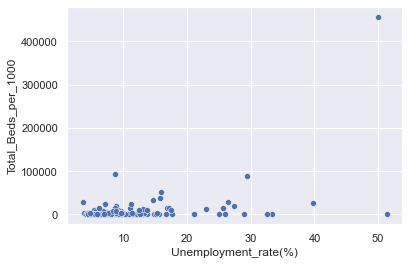

In [69]:
sns.scatterplot(data=homeless, x="Unemployment_rate(%)", y="Total_Beds_per_1000")
# creates a scatterplot of the municipalities; the x-axis has the municipality's unemployment rate
# the y-axis has the municipality's shelter beds per 1000 people

To clean up the scatterplot, outliers at the extremes of either axis will be removed. This is done by putting a maximum limit on certain columns and any rows that exceed the limit will be excluded.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Unemployment_rate(%)', ylabel='Total_Beds_per_1000'>

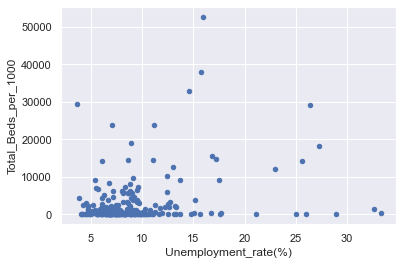

In [73]:
homeless_inliers = homeless[(homeless['Unemployment_rate(%)'] < 35) & # maximum unemployment rate 35%
                  (homeless['Total_Beds_per_1000'] < 80000)] # max beds per 1000 people 80 000

homeless_inliers.plot.scatter(x='Unemployment_rate(%)', y='Total_Beds_per_1000')

Now to run a correlation statistic on this scatterplot.

In [72]:
stats.pearsonr(homeless_inliers['Unemployment_rate(%)'], homeless_inliers['Total_Beds_per_1000'])
# the first value is the Pearson r value, and the second value is the p value

(0.27881404313871827, 5.212401328045882e-06)

The Pearson r value is greater than 0 which means there is a positive relationship between the two variables. As unemployment rate goes up, shelter capacity (and thus homeless prevalence) also goes up. The p value is also quite tiny which means this observed correlation is very unlikely due to random chance. 

Now let's look at how low income prevalence correlates to shelter capacity. 

<AxesSubplot:xlabel='Low_income_rate(%)', ylabel='Total_Beds_per_1000'>

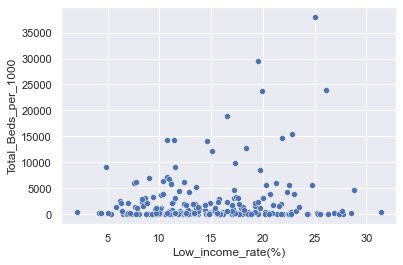

In [87]:
sns.scatterplot(data=homeless, x="Low_income_rate(%)", y="Total_Beds_per_1000")

In [88]:
homeless_sans_null = homeless[homeless['Low_income_rate(%)'].notna()] #removes rows without low income data to allow for correlation analysis

stats.pearsonr(homeless_sans_null['Low_income_rate(%)'], homeless_sans_null['Total_Beds_per_1000'])

(0.1378149278414655, 0.031753315507078037)

Interestingly, the correlation is weaker than with unemployment rate and there's a much higher chance that the correlation found was due to random chance. 

Both low income prevalence and unemployment rate will be used in later analysis, but the correlations found here must be heeded.

### HRM Homeless and Library Analysis

###### Creating a Table of the HPL Branches and the Census Tracts that they Manage

Using `Scholars GeoPortal`'s visualization of the Halifax Regional Municipality (HRM)'s census tracts and the Halifax Public Library (HPL)'s branch locations map, a CSV file listing the census tract codes sorted by nearest HPL branch was manually created `(Ontario Council of University Libraries, 2021)`. 

On Excel, the columns with the sorted census tract IDs were checked for duplicates by applying conditional formatting where cells with duplicate values were highlighted. Highlighted cells within the same HPL branch had one entry deleted. Highlighted cells within different branches were re-evaluated and the branch least accessible to the census tract had their entry deleted. 

The list of sorted census tracts were then checked for missing census tracts. A master list of all HRM census tracts from the Statistics Canada's 2016 census was placed into a separate column. Then, by using an Excel formula (shown below), each census tract from the master list was checked for a match on the sorted list. If any were missing, they would be looked up on the census profile search and was evaluated for which HPL branch would best fit it. 

![figure_1](CSV_Data_Files/Figure_1.png "Excel Formula")

###### Data from Directly Measuring Homeless Populations

The `Everyone Counts 2018` report by the Affordable Housing Association of Nova Scotia that took a measure of the foot traffic of all the homeless shelters on the Halifax peninsula in a single night provides likely some of the most accurate data on the homelessness situation in Halifax. While not comprehensive of the entire HRM, it would still be interesting to see that data visualized. Thus, it will be added to the CSV file `HPL_census.csv`. 

Data from these reports were manually extracted and based on the locations of the shelters were paired with their most proximal HPL branches.

###### Retrieving Census Data in the HRM

Just like in the first part, the census API will be called upon for each census tract to extract data on umemployment rate and low income revalence. The code on how to write on a CSV file without deleting previously written data was obtained from [Stack Overflow](https://stackoverflow.com/questions/20791354/write-to-csv-on-first-empty-line) `(πόδας ὠκύς, 2013)`.

In [4]:
tract = [] # list holds the census tract data

with open('CSV_Data_Files/HRM_Census_tract_HPL_branches_final.csv', newline='') as csvfile: # reads the csv file with the shelter data stored
    tract_reader = csv.reader(csvfile, delimiter=',')
    
    census_temp = [] # temporary storage for census data that we'll grab for each location
    a = 0 # counts the rows in tract
    
    for row in tract_reader: # places the data onto a list (each row of data will be treated as a separate location)
        if len(row) > 0: # ^even though 1 location occupies multiple rows
            tract.append(row) #grabs the shelter data for each row and places it on a list (the list will be placed in a csv later)
            
            if len(row[0]) != 0: # i.e. if the location has a DGUID that links to census data
                
                response = requests.get('https://www12.statcan.gc.ca/rest/census-recensement/CPR2016.json?lang=E&dguid=' + "2016S0507" + str(row[0]) + '&topic=0&notes=0&stat=0')
                # grabs the 2016 census data on the census tract that corresponds to the DGUID
                query = response.json() # retrieve JSON data

                if len(query['DATA']) != 0: #checks if the JSON data actually has census data
                    census_temp.append(query['DATA'][0][1]) # adds province to list (for checking purposes, will delete on excel later)
                    census_temp.append(query['DATA'][0][4]) # adds census tract to list (for checking purposes, will delete on excel later)
                    census_temp.append(query['DATA'][1871][13]) # adds unemployment rate to list
                    census_temp.append(query['DATA'][856][13]) # adds low income prevalence % to list
                    census_temp.append(query['DATA'][0][13]) # adds population to list
                        
                    tract[a].extend(census_temp) # adds the census data to the row of homeless shelter data

                    census_temp.clear() #cleans the census data list holder for the next row
        
            with open('HPL_census.csv', 'a', newline='') as csvfile: # appends 'shelt' list to a new CSV file
                census_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
                census_writer.writerow(tract[a])
                # https://stackoverflow.com/questions/20791354/write-to-csv-on-first-empty-line
            
            print(tract[a]) # visually shows process of data extraction
            a += 1 # counts up a
                

['2050003.00', 'Central', 'Nova Scotia', '0003.00', 8.6, 20.0, 2955.0]
['2050005.00', 'Central', 'Nova Scotia', '0005.00', 11.3, 8.3, 1808.0]
['2050004.02', 'Central', 'Nova Scotia', '0004.02', 15.3, 41.5, 4771.0]
['2050004.01', 'Central', 'Nova Scotia', '0004.01', 12.0, 36.4, 3466.0]
['2050006.00', 'Central', 'Nova Scotia', '0006.00', 9.4, 18.2, 3129.0]
['2050007.00', 'Central', 'Nova Scotia', '0007.00', 16.1, 23.5, 1859.0]
['2050008.00', 'Central', 'Nova Scotia', '0008.00', 8.1, 35.6, 2778.0]
['2050013.00', 'Central', 'Nova Scotia', '0013.00', 7.7, 9.6, 2561.0]
['2050012.00', 'Central', 'Nova Scotia', '0012.00', 10.6, 13.6, 2482.0]
['2050009.00', 'Central', 'Nova Scotia', '0009.00', 6.0, 22.2, 2357.0]
['2050018.00', 'Halifax North Memorial Public Library ', 'Nova Scotia', '0018.00', 8.3, 17.8, 3544.0]
['2050011.00', 'Halifax North Memorial Public Library ', 'Nova Scotia', '0011.00', 7.2, 20.9, 5631.0]
['2050010.00', 'Halifax North Memorial Public Library ', 'Nova Scotia', '0010.00', 

['2050108.00', 'Alderney Gate Public Library', 'Nova Scotia', '0108.00', 6.7, 7.0, 4769.0]
['2050111.00', 'Farrell Hall / Dartmouth North Temporary Location', 'Nova Scotia', '0111.00', 10.7, 23.3, 3132.0]
['2050112.00', 'Farrell Hall / Dartmouth North Temporary Location', 'Nova Scotia', '0112.00', 7.8, 36.8, 2014.0]
['2050114.00', 'Farrell Hall / Dartmouth North Temporary Location', 'Nova Scotia', '0114.00', 10.9, 35.8, 6569.0]
['2050113.00', 'Farrell Hall / Dartmouth North Temporary Location', 'Nova Scotia', '0113.00', 9.4, 20.5, 1317.0]


Like above, the CSV file containing the data will be placed into a dataframe.

In [3]:
hpl_csv = pd.read_csv("HPL_census.csv") # reads the HPL data CSV

hpl = pd.DataFrame() # create a new data frame for HPL data

hpl['DGUID'] = hpl_csv['DGUID'] # these lines add the columns from the CSV onto the dataframe

hpl['HPL_branch'] = hpl_csv['HPL']

hpl['Province'] = hpl_csv['Province']

hpl['Census_tract'] = hpl_csv['Census_Tract']

hpl['Unemployment_rate(%)'] = hpl_csv['Unemployment_rate']

hpl['Low_income_rate(%)'] = hpl_csv['Low_income']

hpl['Population'] = hpl_csv['pop']

hpl['Shelter'] = hpl_csv['Shelter']

hpl['Occupants'] = hpl_csv['occupants']

hpl.head()

,DGUID,HPL_branch,Province,Census_tract,Unemployment_rate(%),Low_income_rate(%),Population,Shelter,Occupants
0,2050003.00,Central,Nova Scotia,3.00,8.6,20.0,2955,NaN,0
1,2050005.00,Central,Nova Scotia,5.00,11.3,8.3,1808,Phoenix Youth Shelter,13
2,2050004.02,Central,Nova Scotia,4.02,15.3,41.5,4771,NaN,0
3,2050004.01,Central,Nova Scotia,4.01,12.0,36.4,3466,NaN,0
4,2050006.00,Central,Nova Scotia,6.00,9.4,18.2,3129,NaN,0


###### Analysing the Homeless Situation in the HRM 

In the previous section, it was demonstrated that there is a correlation between unemployment rate and the need for shelter bed capacity. Thus, if we take the unemployment rate of each HPL branch service area we can have an idea which areas need more assistance for persons experiencing homelessness. Nonetheless, it would be prudent to visualize the data for low income rate, so that will be done as well. 

When it comes to addressing homelessness, the absolute number of individuals experiencing homelessness matters more than the rate of homelessness in a given region. A less populated region can show a large % of homelessness, but their absolute numbers may be lower than a more populated region with what appears to be a lower % of homelessness. Thus, the unemployment rate will be multiplied by the census tract population to get the number of unemployed people in that census tract which is correlated to the number of homeless individuals in the area. 

<AxesSubplot:xlabel='HPL_branch'>

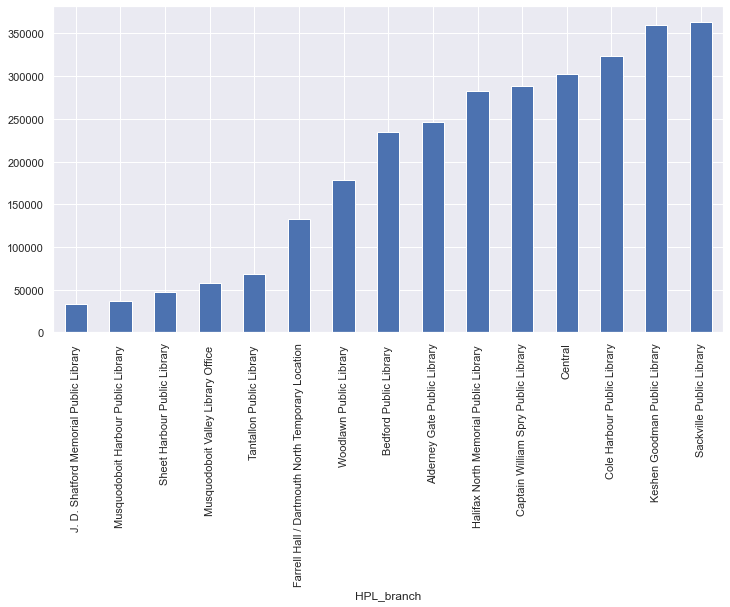

In [4]:
hpl['Unemployed_pop'] = hpl['Unemployment_rate(%)'] * hpl['Population'] 
# calculates the number of unemplyed people and extends the dataframe with those values

unemp = hpl.groupby('HPL_branch') # group by hpl branch

unemp['Unemployed_pop'].sum().sort_values().plot.bar(figsize=(12,6)) 
# graphs total of unemployed people per HPL branch service area and sorts them 

Based on unempliyment rate, it looks like either `Sackville Public Library` or `Keshen Goodman Public Library` would be good candidates for a social worker.

Let's repeat it for the low income prevalence.

<AxesSubplot:xlabel='HPL_branch'>

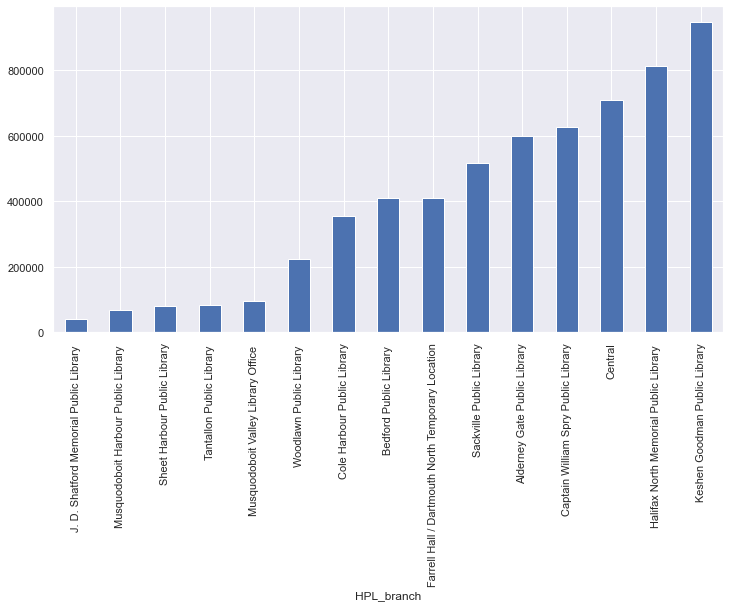

In [5]:
hpl['Low_Income_pop'] = hpl['Low_income_rate(%)'] * hpl['Population'] 
# calculates the number of low income people and extends the dataframe with those values

unemp = hpl.groupby('HPL_branch') # group by hpl branch

unemp['Low_Income_pop'].sum().sort_values().plot.bar(figsize=(12,6)) 
# graphs total of unemployed people per HPL branch service area and sorts them 

Based on Low Income, it looks as if `Keshen Goodman Public Library` or `Halifax North Memorial Public Library` are good candidate for a social worker. 

###### Analysing Homeless Reports Data

The `Everyone Counts 2018` report by Affordable Housing Association of Nova Scotia has a measure of how many people stayed in each shelter on a single night. Each shelter is located within an HPL branch area. Therefore by adding up the number of people that stayed in all the shelters within an HPL branch area, we can have an idea of how many homeless people there were in that particular area that night.

That data that has been processed into the data frame will be visualized in a bar chart.

<AxesSubplot:xlabel='HPL_branch'>

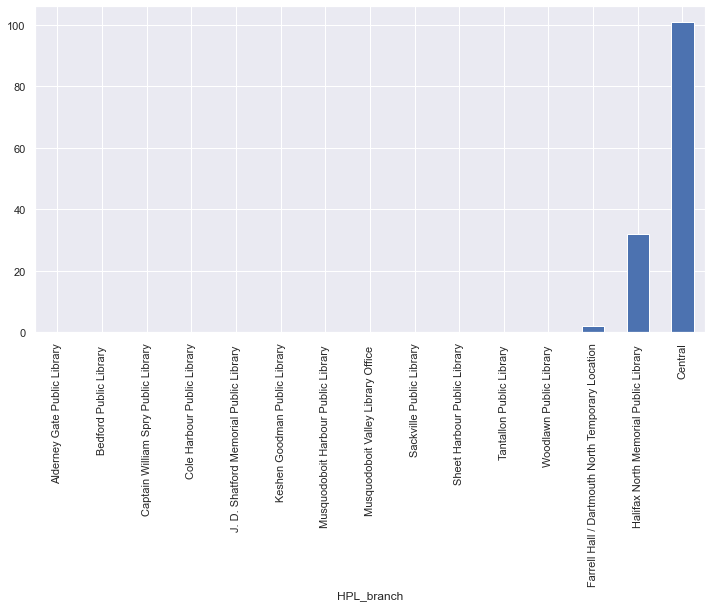

In [6]:
unemp['Occupants'].sum().sort_values().plot.bar(figsize=(12,6)) 
# graphs total of homeless people per HPL branch service area and sorts them 

This data isn't terribly helpful for our present analysis. Perhaps if the report was repeated again at a greater scale, it would be more relevant for our purposes. 

###### Conclusions

Based on the analysis, the HRM would see the most benefit if a social worker were placed in either the `Keshen Goodman Public Library` or `Halifax North Memorial Public Library` or `Sackville Public Library` branches with `Keshen Goodman Public Library`being the most reccomended branch. 

There are limitations to the analysis however. I only looked at the homeless situation from a few variables. Perhpas a stronger correlation can be found with other census statistics. This analysis is also purely quantitative. A qualitative insight into the needs and lives of marginalized peoples that frequent each branch and the staff would also provide valuable insight. 

#### References

Affordable Housing Association of Nova Scotia. (2018). Everyone Counts: Report on the 2018 Halifax Point in Time Count. https://www.homelesshub.ca/sites/default/files/attachments/2018%2BHalifax%2BPoint%2Bin%2BTime%2BCount%2BReport.pdf

Clink, K. (2020). Look for the Helpers: Public Libraries and the Homeless: A Literature Review. PNLA Quarterly, 15–25.

Halifax Public Libraries. (2021). Locations | Halifax Public Libraries. BiblioEvents. https://halifax.bibliocommons.com/locations

Lloyd, P. (2020). The Public Library as a Protective Factor: An Introduction to Library Social Work. Public Library Quarterly, 39(1), 50–63. https://doi.org/10.1080/01616846.2019.1581872

Ontario Council of University Libraries. (2021). Scholars GeoPortal. http://geo1.scholarsportal.info/#_lang=en

πόδας ὠκύς. (2013, December 26). Write to CSV on first empty line [duplicate]. Stack Overflow. https://stackoverflow.com/questions/20791354/write-to-csv-on-first-empty-line

Skultety, A. (2020, February 14). For Halifax’s only library social worker, a ‘circle of care’ extends to all. The Signal. https://signalhfx.ca/for-halifaxs-only-library-social-worker-a-circle-of-care-extends-to-all/

Statistics Canada. (2017a, February 8). Census Profile, 2016 Census—Halifax [Population centre], Nova Scotia and Nova Scotia [Province]. https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=POPC&Code1=0348&Geo2=PR&Code2=12&SearchText=Halifax&SearchType=Begins&SearchPR=01&B1=All&TABID=1&type=0

Statistics Canada. (2017b, August 30). Homeless shelter capacity, bed and shelter counts for emergency shelters, transitional housing and violence against women shelters for Canada and provinces, Employment and Social Development Canada annual (number). https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410035301

Statistics Canada. (2019a, November 13). Dissemination Geography Unique Identifier: Definition and Structure. https://www150.statcan.gc.ca/n1/pub/92f0138m/92f0138m2019001-eng.htm

Statistics Canada. (2019b, November 13). 2016 Census Profile Web Data Service (WDS) - User Guide. https://www12.statcan.gc.ca/wds-sdw/cpr2016-eng.cfm
